In [1]:
# data exploration and manipulation
import pandas as pd
from collections import Counter

# ancilliary utility modules
from FileTools import FileTools  # see github.com/romstroller/FileTools
import dataUtls  # source in repository

### OBJECTIVE
This report is a broad exploration of World Factbook data from the US Central 
Intelligence Agency, seeking to provide general point-of-interest insights on 
key data points in global health, age, gender, economy, energy and environemnt, 
with the help of sample maximum/minimum bar graphs (i.e. "top tens"), and 
correlated-feature scatter plots.

Some questions examined...
- Generational weight disparity: in what countries are both the adults 
most overweight and the children most underweight?


### DATA acquisition, cleaning and feature engineering

In [2]:
# authenticate, download and load kaggle dataset
dffBook = FileTools().getKaggleSet( 'lucafrance', 'the-world-factbook-by-cia' )

Waiting for dataset download
Latest: the-world-factbook-by-cia.zip
Got DF from extracted dSet at:
 C:\Users\romstroller\PYC\ciaFactBook\data_or\countries.csv


In [3]:
# count unique data types
Counter( [ i[ 1 ] for i in dffBook.dtypes.items() ] ).most_common()

[(dtype('O'), 1044), (dtype('float64'), 10)]

#### State of information

- *[The World Factbook by CIA](https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia)
by Luca Franceschini on Kaggle*

The dataset, which is documented to have been provided via web scraping, largely 
comprises ambiguous object-type values, for which the only sensible cast is 
string. 

For the subset of features which afford straightforward numeric analysis, 
the primary values are obfuscated, in inconsistent format, by extraneous 
information, including historical values along with scale notation and other 
notes. Processing will produce the primary numeric value in float type, and 
reduce null values to a minimum (currently the majority of values are NaN). 

For clarity, source code for cleaning operations is located in dataUtls module.

In [4]:
# Num-parsing dict, regex: r'([+-]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|\d*\.\d+|\d+)'
dfFbDict = dataUtls.generateMatchDct( dffBook )

# isolate clean float from number-match records
dataUtls.isolateClean( dfFbDict )

# generate dataframe from clean feature data
dfFloat = dataUtls.getCleanDF( dfFbDict, dffBook )

# Enforce non-nan threshold ( av. dense + .5 sDev rounded ), convert numeric
dfColsClean = dataUtls.getNumericNonNan( dfFloat )

# Review clean DF
print( dataUtls.cleanReport( dffBook, dfColsClean ) )

factbook originally shape: (258, 1054)
    NAN-density: 73.81% (200708 NaN in 271932 values)
clean dataframe has shape: (258, 249)
    NAN-density: 22.14% (14221 NaN in 64242 values)



In [5]:
# Manual analysis: feature scale differences, identifiable primary number value
# dataUtls.runScaleAnalysis(dfColsClean, cleanReman)

# Load completed scale/drop analysis
dropFeats, scaleNotes = dataUtls.loadSDdata()

# apply drop to flagged features
dfDropped = dataUtls.omitDropped( dfColsClean, dropFeats )

In [6]:
# adjust flagged values to unify scale
df, cleanCountries = dataUtls.flattenScale(
    dfDropped, dfFbDict, scaleNotes, dffBook, dropFeats )

pd.options.display.float_format = '{:,.2f}'.format

In [7]:
# remove "World" summative record
df = df[ df.Country != 'World' ].copy()

### Exploration, Visualisation and Analysis

##### Reporting is broadly categorized into observations on:
- Age, health and gender
- COAL, ENGERY AND POLLUTION
- ECONOMY
- GEOGRAPHY AND ENVIRONMENT

In [8]:
# provide local access to required module data tools
showT10 = dataUtls.showTopTen  # barplot for <=10 feature-max/min countries 
cycleT10 = dataUtls.cycleT10  # cycle features through show10
pltSctr = dataUtls.plotScttr  # scatterplot distribution for feature pair
getRank = dataUtls.getRank  # return country's rank for value for feature
getVal = dataUtls.getVal  # return val for country for feature
getCorDct = dataUtls.getCorDct  # generate feature master correl. dict
getCTDict = dataUtls.getCThreshDct  # get dict for correlations at threshold
getTRep = dataUtls.getThreshReport  # report correlations-at-threshold
repCorr = dataUtls.repCorrel  # report correlation for feature pair
difsFld = dataUtls.showDiffsFilled  # For corrThreshDct, omit NaN-only diffs

In [9]:
# Re. CORRELS

# Stronger correlations will tend to be more self-evident, but provide an 
#   empirical, observational basis for testing easy assumptions. 
#   Scatter plots are useful for identifying or demonstrating where a clear 
#       pattern, like a linear correlation, is present, and also for 
#       an alternative view on observations made with different techniques.


In [10]:
corrDct = getCorDct( df )

Completed correlations


In [11]:
# Check perfect correlations: Confirmed duplicates, dropping
for i in getCTDict( 1, corrDct, df ): corrDct.pop( i )

In [12]:
# Lower threshold, likely still duplicates with some noise
thresh_9_9_9 = getCTDict( 0.999, corrDct, df )
for i in thresh_9_9_9: print( f"{getTRep( thresh_9_9_9, i )}" )

CORRELATION FOR FEAT-PAIR [11, 77]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999999999999999
BASE: Geography: Land use - other
COMP: Environment: Land use - other

CORRELATION FOR FEAT-PAIR [112, 69]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999999999999999
BASE: Economy: Unemployment, youth ages 15-24 - total
COMP: People and Society: Unemployment, youth ages 15-24 - total

CORRELATION FOR FEAT-PAIR [113, 70]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999999999999999
BASE: Economy: Unemployment, youth ages 15-24 - male
COMP: People and Society: Unemployment, youth ages 15-24 - male

CORRELATION FOR FEAT-PAIR [120, 119]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9995297069555054
BASE: Economy: Budget - expenditures
COMP: Economy: Budget - revenues

CORRELATION FOR FEAT-PAIR [131, 164]
IN THRESHOLD +-=[ 0.999-inf ] 
CORR: 0.9999976432982164
BASE: Energy: Electricity - Installed generating capacity
COMP: Energy: Carbon dioxide emissions - From petroleum and other liquids

CORRELATION FOR FEAT-PAIR 

In [13]:
checkDifs_9_9_9 = difsFld( thresh_9_9_9, df )
# Proof: having more land almost always makes your country bigger!
# For same feature name: at this range, all diffs NaN,
#   but NaN at different positions? Does merging cols enhance the feature? 

[11, 77]: diffs all NaN
[112, 69]: diffs all NaN
[113, 70]: diffs all NaN

224 Non-NaN diffs for [120, 119]. First 3:


,Country,Economy: Budget - expenditures,Economy: Budget - revenues
0,Afghanistan,5.33,2.28
2,Albania,3.87,3.61
3,Algeria,70.20,54.15



172 Non-NaN diffs for [131, 164]. First 3:


,Country,Energy: Electricity - Installed generating capacity,Energy: Carbon dioxide emissions - From petroleum and other liquids
0,Afghanistan,"776,000.00",3.47
2,Albania,2.53,3.48
3,Algeria,21.69,57.87



124 Non-NaN diffs for [144, 145]. First 3:


,Country,Energy: Coal - Production,Energy: Coal - Consumption
2,Albania,"9,000.00","119,000.00"
3,Algeria,0.00,"85,000.00"
10,Argentina,"829,000.00",1.55



171 Non-NaN diffs for [144, 164]. First 3:


,Country,Energy: Coal - Production,Energy: Carbon dioxide emissions - From petroleum and other liquids
0,Afghanistan,2.10,3.47
2,Albania,"9,000.00",3.48
3,Algeria,0.00,57.87



171 Non-NaN diffs for [145, 164]. First 3:


,Country,Energy: Coal - Consumption,Energy: Carbon dioxide emissions - From petroleum and other liquids
0,Afghanistan,2.10,3.47
2,Albania,"119,000.00",3.48
3,Algeria,"85,000.00",57.87


In [14]:
thresh_995_999 = getCTDict( 0.995, corrDct, df, out_lim=0.999 )
for i in thresh_995_999: print( f"{getTRep( thresh_995_999, i )}" )
checkDifs_995_998 = difsFld( thresh_995_999, df )


CORRELATION FOR FEAT-PAIR [24, 23]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9965314599297501
BASE: People and Society: Median age - male
COMP: People and Society: Median age - total

CORRELATION FOR FEAT-PAIR [41, 42]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9985392452149099
BASE: People and Society: Infant mortality rate - total
COMP: People and Society: Infant mortality rate - male

CORRELATION FOR FEAT-PAIR [41, 43]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9976671587641676
BASE: People and Society: Infant mortality rate - total
COMP: People and Society: Infant mortality rate - female

CORRELATION FOR FEAT-PAIR [165, 191]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9959652112808556
BASE: Energy: Carbon dioxide emissions - From consumed natural gas
COMP: Transportation: Heliports

CORRELATION FOR FEAT-PAIR [184, 181]
IN THRESHOLD +-=[ 0.995-0.999 ] 
CORR: 0.9970544928634651
BASE: Transportation: Airports - with paved runways - 1,524 to 2,437 m
COMP: Transportation: Airports - with paved 

,Country,People and Society: Median age - male,People and Society: Median age - total
0,Afghanistan,19.40,19.50
2,Albania,32.90,34.30
3,Algeria,28.60,28.90



226 Non-NaN diffs for [41, 42]. First 3:


,Country,People and Society: Infant mortality rate - total,People and Society: Infant mortality rate - male
0,Afghanistan,104.89,113.33
2,Albania,10.82,11.85
3,Algeria,19.72,21.77



226 Non-NaN diffs for [41, 43]. First 3:


,Country,People and Society: Infant mortality rate - total,People and Society: Infant mortality rate - female
0,Afghanistan,104.89,96.03
2,Albania,10.82,9.71
3,Algeria,19.72,17.55



97 Non-NaN diffs for [165, 191]. First 3:


,Country,Energy: Carbon dioxide emissions - From consumed natural gas,Transportation: Heliports
3,Algeria,93.41,4.00
6,Angola,1.69,1.00
8,Antarctica,0.00,53.00



166 Non-NaN diffs for [184, 181]. First 3:


,Country,"Transportation: Airports - with paved runways - 1,524 to 2,437 m",Transportation: Airports - with paved runways - total
0,Afghanistan,12.00,29.00
2,Albania,1.00,3.00
3,Algeria,18.00,67.00


In [15]:
# start = 167
# cycleT10(  df, start, 1 )
# start +=1

In [16]:
# not hard to see where all the accountants live
# Economy: GDP - composition, by sector of origin - services

# why is GDP-by-gov-consump t10 purely small island-states?
# Economy: GDP - composition, by end use - government consumption

# gdp-by-imports: maldives only positive, and vastly so [...]
# Economy: GDP - composition, by end use - imports of goods and services

# libya experiencing the largest indust. growth by fair
# Economy: Industrial production growth rate

# Kenya % Geothermal (Energy: Electricity generation sources - Geothermal)
# In places where tectonic plates – consisting of the Earth's crust, and the 
# upper mantle – are being pushed together or torn apart, this heat rises closer 
# to the surface. One such place is Africa's Great Rift Valley, which runs 
# 7,000km (4,350 miles) across the eastern side of the continent.

# Most "militarized", NK many times more than any other
# Military and Security: Military expenditures


#### Age, health and gender

Percent population aged 65+
<font color='red'> (citReq) Monaco and then Japan both stand conspicuously out from the distribution.
Futher research could establish if it is an older people who can afford 
Monaco's prestigious cost of living while, on the other hand, if Japan has a 
trend in restrained birth rate, with young adults prioritizing career 
ascension over family-making.</font>

People and Society: Age structure - 65 years and over


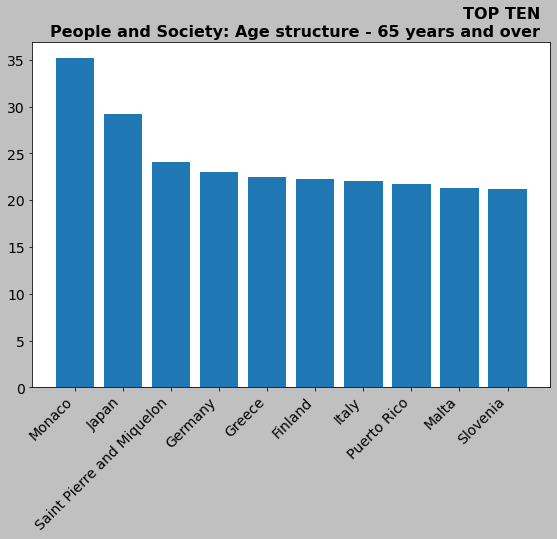

In [17]:
showT10( 'People and Society: Age structure - 65 years and over', df )

Japan takes the lead with the ratio of younger adults who might be able to 
take on a supporting role to the elderly, while there was no data for Monaco.

People and Society: Dependency ratios - potential support ratio


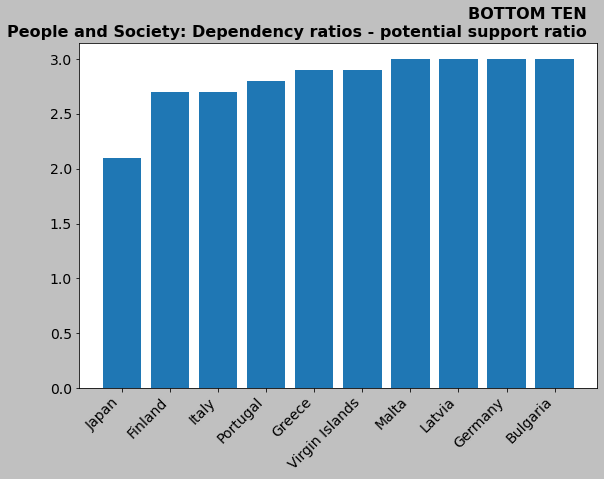

Monaco is null for
People and Society: Dependency ratios - potential support ratio


In [18]:
showT10( 'People and Society: Dependency ratios - potential support ratio',
    df, asc=True )

getRank( df, 'Monaco',
    'People and Society: Dependency ratios - potential support ratio' )

People and Society: Sex ratio - 25-54 years


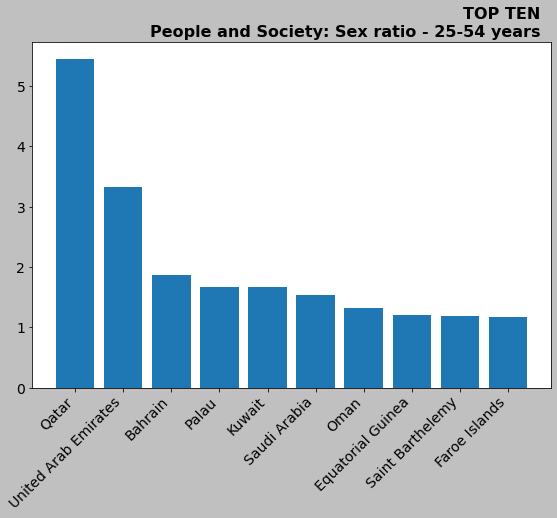

People and Society: Sex ratio - 55-64 years


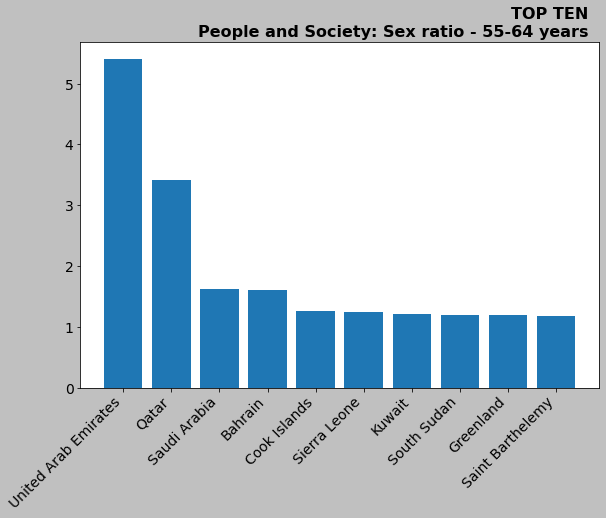

People and Society: Age structure - 25-54 years


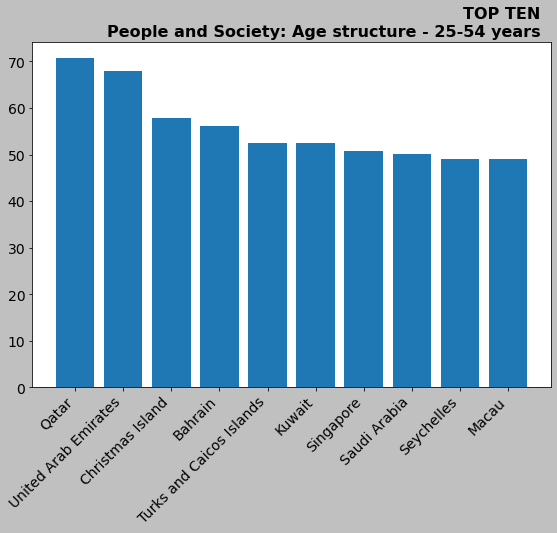

People and Society: Dependency ratios - potential support ratio


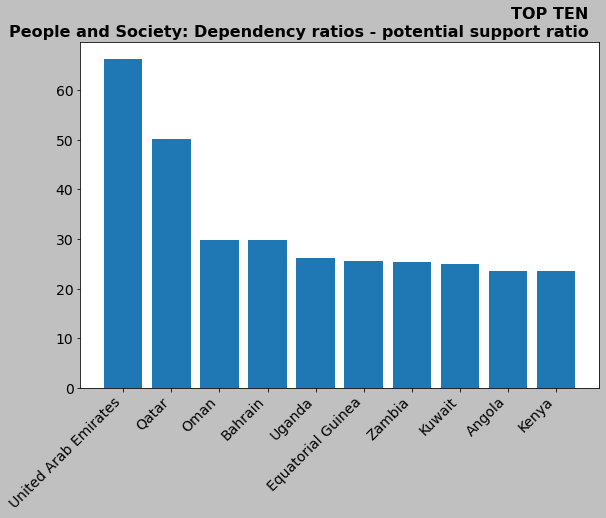

People and Society: Sex ratio - 65 years and over


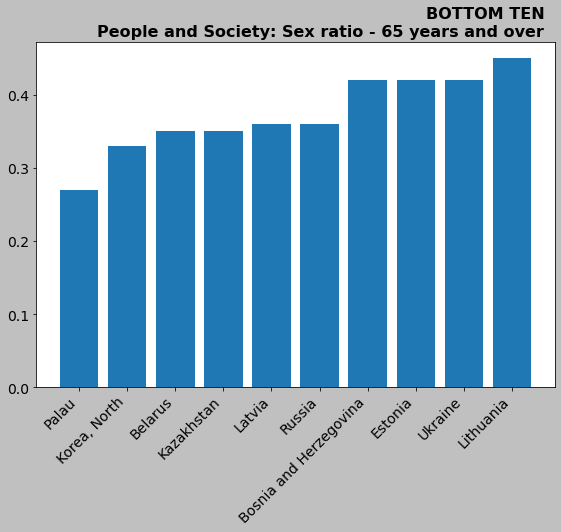

In [19]:
# Qatar & UAE's men-to-women ratios in the 25-54yo, 55-64yo and 65+ brackets 
# are startlingly weighted to men, the strongest in the world.
showT10( 'People and Society: Sex ratio - 25-54 years', df )
showT10( 'People and Society: Sex ratio - 55-64 years', df )
# At the same time, both have (by good measure) the highest value for
# the percentage of total population that is 25-54 years old.
showT10( 'People and Society: Age structure - 25-54 years', df )
# Interesting combination - purely speculating, one can imagine a dominating
# social discourse might concern the relation of older men to working-age adults.
# This consideration is furnished with the dependency ratio, in which
# UAE and Qatar are by very, very far the the world chart-toppers:
showT10( 'People and Society: Dependency ratios - potential support ratio', df )
# (What is the DR, and how would these three figures relate?)

# meanwhile, in Palau and North Korea, in the 65+ bracket, there are more than 
# twice as many old codgettes as old codgers.
showT10( 'People and Society: Sex ratio - 65 years and over', df, asc=True )

Feats: [ People and Society: Age structure - 55-64 years ]
       [ People and Society: Urbanization - rate of urbanization ]


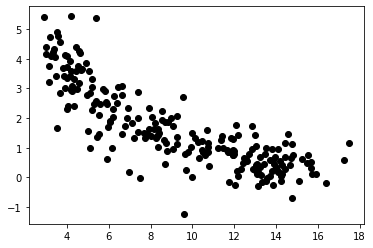

Feats: [ People and Society: Age structure - 55-64 years ]
       [ Communications: Broadband - fixed subscriptions - subscriptions per 100 inhabitants ]


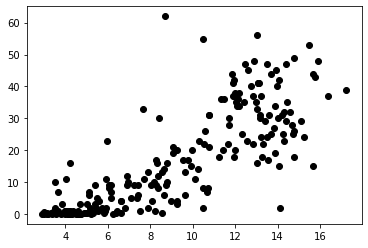

Feats: [ People and Society: Age structure - 65 years and over ]
       [ Communications: Broadband - fixed subscriptions - subscriptions per 100 inhabitants ]


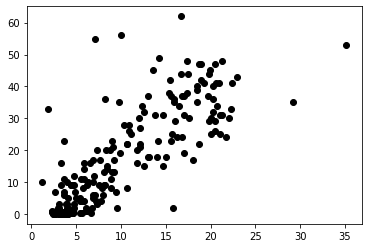

In [20]:
# "Older pop = lower urb'stn" (curvilinear) yet more br'band subs"
pltSctr( df, [
    'People and Society: Age structure - 55-64 years',
    'People and Society: Urbanization - rate of urbanization' ] )
pltSctr( df, [
    'People and Society: Age structure - 55-64 years',
    f'Communications: Broadband - fixed subscriptions - '
    f'subscriptions per 100 inhabitants' ] )
pltSctr( df, [
    'People and Society: Age structure - 65 years and over',
    f'Communications: Broadband - fixed subscriptions - subscriptions '
    f'per 100 inhabitants' ] )
# Higher med. age = +physicians, -fertility, +broadband subscriptions


People and Society: Current Health Expenditure


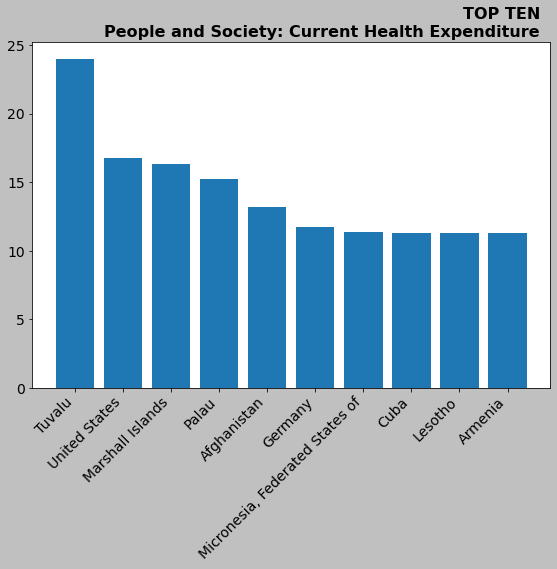

People and Society: Physicians density


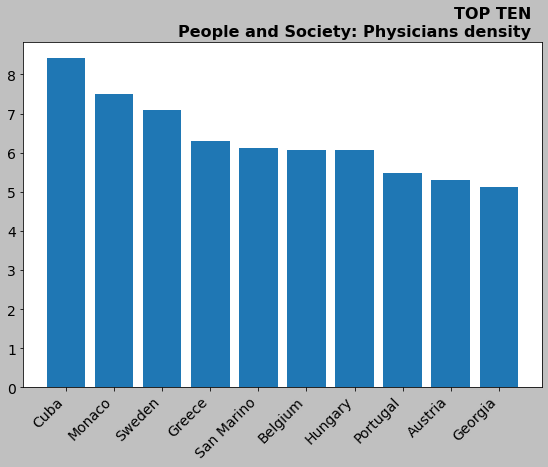

People and Society: Current Health Expenditure


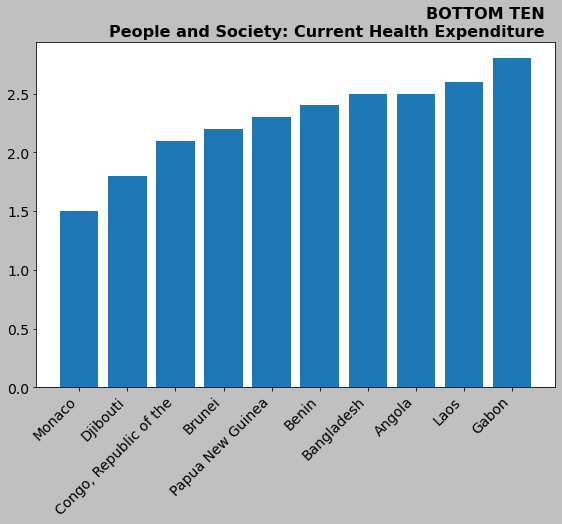

In [21]:
# People and Society: Current Health Expenditure
# Surprised to see US near the top with the impression given by private health 
# costs.
showT10( 'People and Society: Current Health Expenditure', df )
# Only one country in t10 expenditure is also in t10 physician density (Cuba)
showT10( 'People and Society: Physicians density', df )
# physician density strikes me as vital, as a population's relationship with
#   health-seeking, at a preventative stage, [is tied] to its familiarity and 
#   access to responsive human consultation.
# Nice littel one-liner aside: Cuba provides more medical personnel to the 
#   developing world than all the G8 countries combined.

# The only "first-world" country in bottom-10 health expenditure, indeed
#   leading it, is Monaco, which happens also to:
#       - have the second-highest physician density
#       - top the "% pop is 65+"
#   So, with such an old population and such a high density of physicians, 
#   it may be safe to assume that it is an excellent destination for 
#   private medical enterprise
showT10( 'People and Society: Current Health Expenditure', df, asc=True )

People living with HIV/AIDs as percentage of population


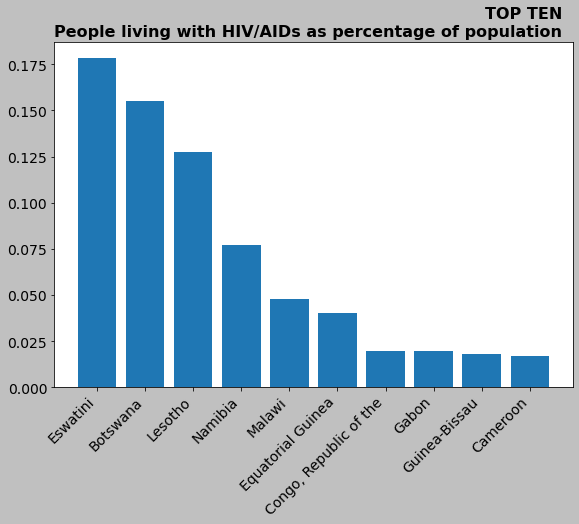

People living with HIV/AIDs as percentage of population


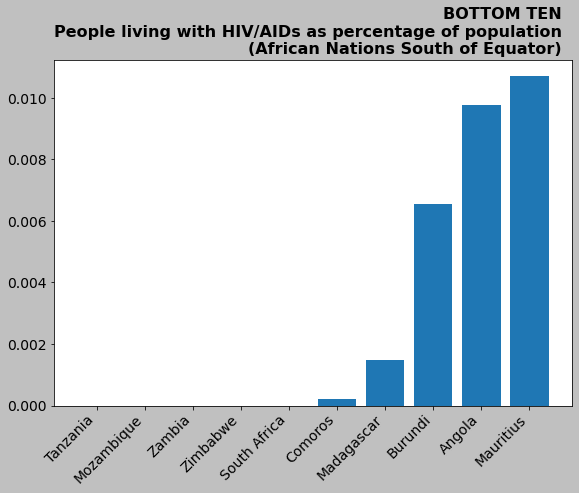

In [22]:
# Southern Africa nations exclusively form the t10 %pop with HIV-AIDs
df[ 'People living with HIV/AIDs as percentage of population' ] = (
    df[ 'People and Society: HIV/AIDS - people living with HIV/AIDS' ] /
    df[ 'People and Society: Population' ])
showT10( 'People living with HIV/AIDs as percentage of population', df )

# one becomes curious which SA nation has the lowest population with HIV/AIDs
sthEquatAfrica = dffBook[
    (dffBook[ "Geography: Map references" ] == "Africa")
    & (dffBook[ "Geography: Geographic coordinates" ].str.contains( "S" ))
].Country

showT10( 'People living with HIV/AIDs as percentage of population',
    df[ df[ 'Country' ].isin( sthEquatAfrica ) ], asc=True,
    subtitle="African Nations South of Equator" )

For the countries that are not islands, Angola - being large, and close to the
HIV/AIDs epicentre, appears to have some form of strongly inhibiting factor.
A look at recent history identifies a cause for the low prevalence: civil war. 

> The 27-year civil war in Angola, lasting from 1975 until 2002, kept the spread 
> of HIV to a minimum due to large parts of the country being inaccessible to 
> people infected with the virus. During the civil war, individuals from 
> neighboring countries such as Zambia, Botswana, and Zimbabwe (all countries 
> with high prevalence rates of HIV) were also not allowed to come into the 
> country, which played a significant role in controlling the spread of HIV.
> [(source: Wikipedia)](https://en.wikipedia.org/wiki/HIV/AIDS_in_Angola#History)

People and Society: Tobacco use - total


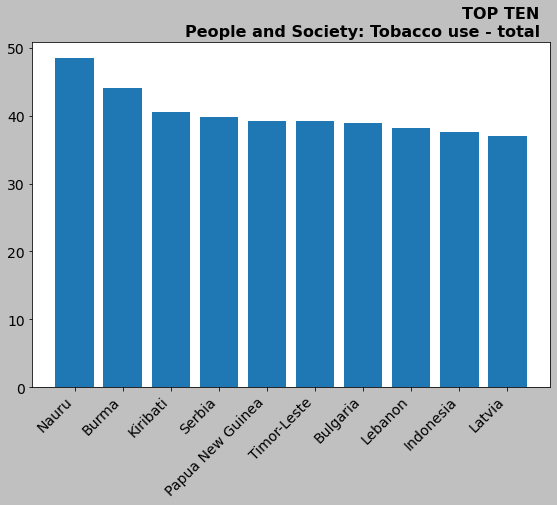

People and Society: Tobacco use - male


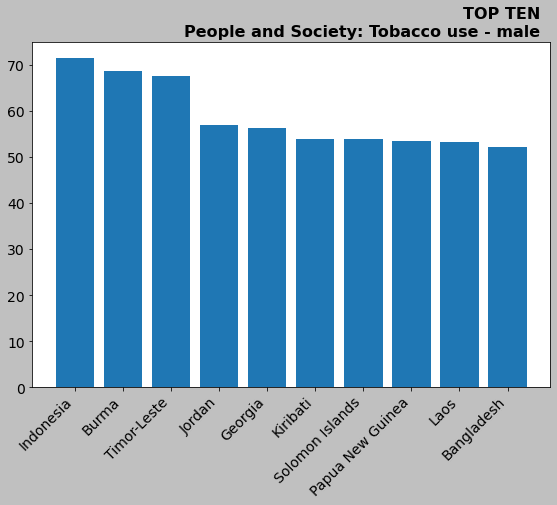

People and Society: Tobacco use - female


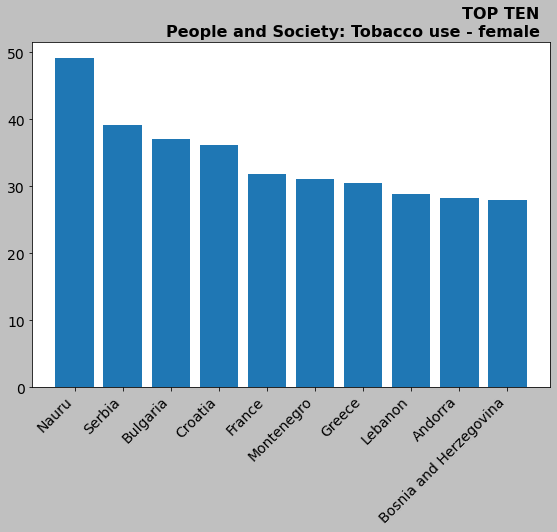

People and Society: Tobacco use - total


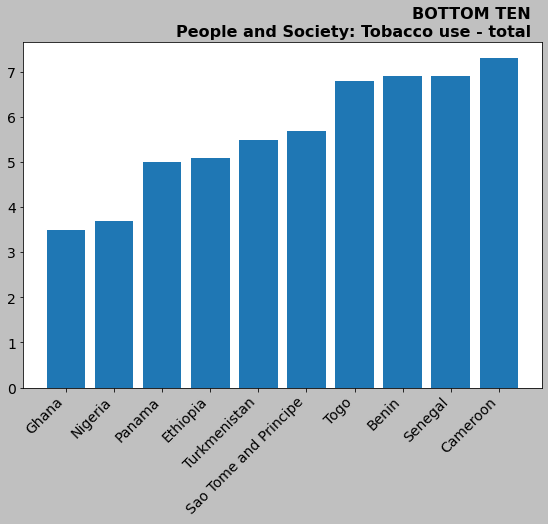

In [23]:
# Nearly half the people in Nauru and Burma smoke
showT10( 'People and Society: Tobacco use - total', df )
# However, when limited to females, whereas European nations remain in the t10,
# the Asia-Pacific nations Burma, Kiribati, Timor Leste, PNG and Indonesia 
# disappear ( whereas for men they remain).  
#   - Gender associations with the act of smoking? 
#     (eg.: "smoking is manly (positive) and/or unwomanly (negative)"

# Pattern strikingly reversed for Nauru (#1 t10:total/women, not in t10:men).
showT10( 'People and Society: Tobacco use - male', df )
showT10( 'People and Society: Tobacco use - female', df )

# No Smoking:
showT10( 'People and Society: Tobacco use - total', df, asc=True )

Generational weight disparity


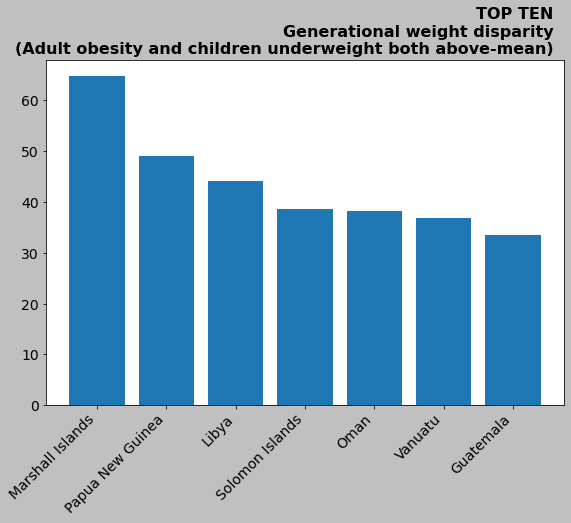

In [24]:
# who has the highest combined score for both adult obesity prevalence and 
# children 4- underweight, where both scores are above feature mean?

uFeat = 'People and Society: Children under the age of 5 years underweight'
oFeat = 'People and Society: Obesity - adult prevalence rate'

df[ 'Generational weight disparity' ] = (df[ uFeat ] + df[ oFeat ])

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, uFeat ].iloc[ 0 ]
    >= df[ uFeat ].mean() and
    df.loc[ df[ 'Country' ] == country, oFeat ].iloc[ 0 ]
    >= df[ oFeat ].mean()) ]

showT10( 'Generational weight disparity',
    df[ df[ 'Country' ].isin( aboveMeans ) ],
    subtitle="Adult obesity and children underweight both above-mean" )

People and Society: School life expectancy (primary to tertiary education) - total


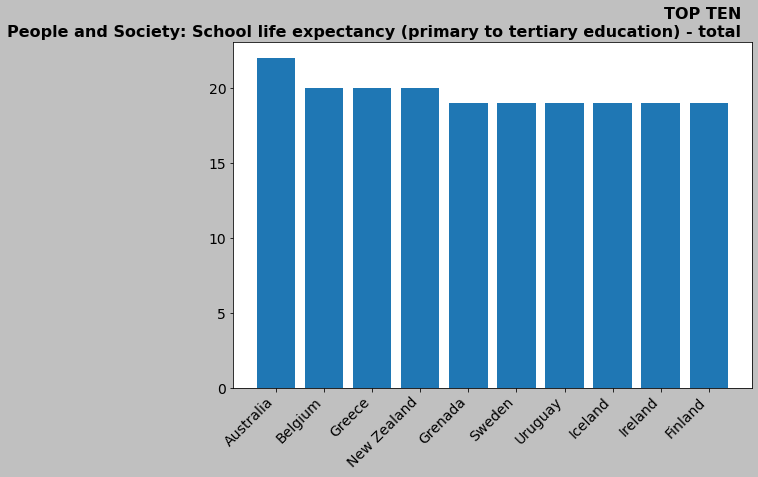

People and Society: School life expectancy (primary to tertiary education) - male


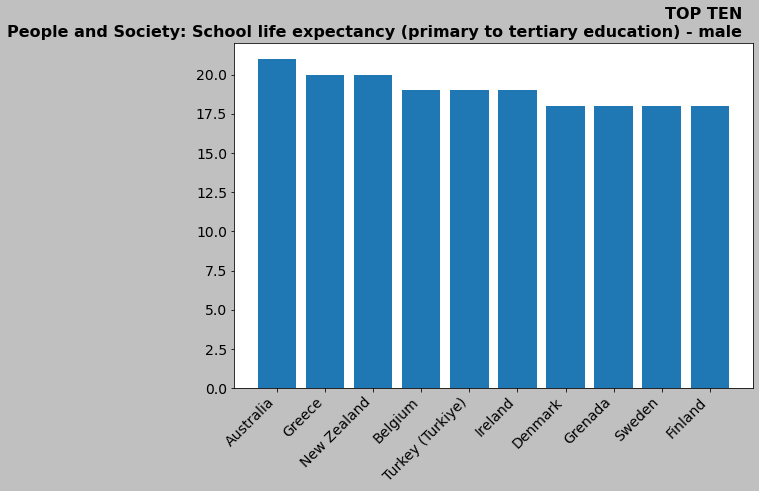

People and Society: School life expectancy (primary to tertiary education) - female


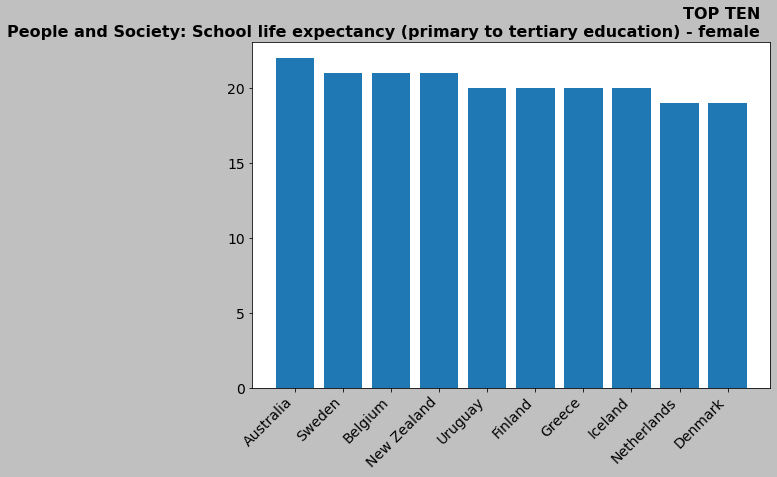

Feats: [ People and Society: School life expectancy (primary to tertiary education) - female ]
       [ People and Society: Infant mortality rate - male ]


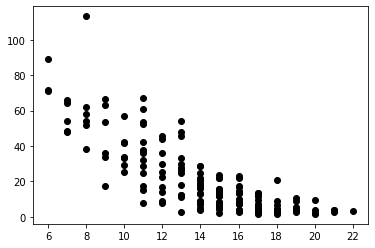

School completion disparity between sexes


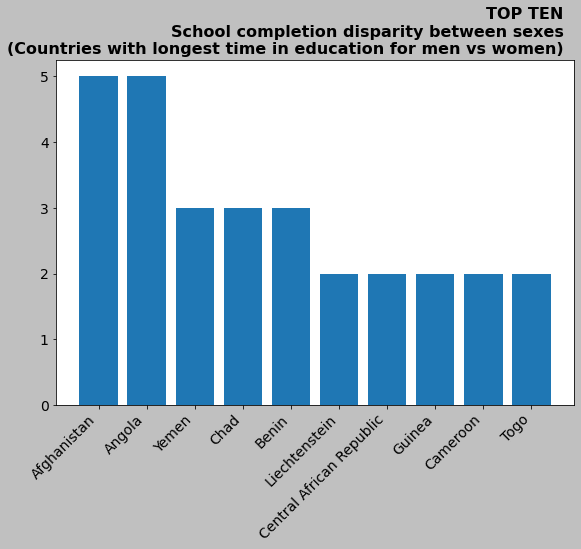

School completion disparity between sexes


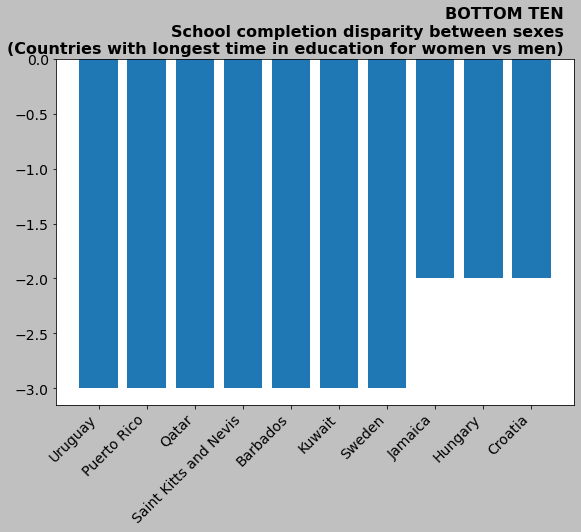

In [25]:
# EDUCATION DISPARITIES:
expectFeatStr = (
    "People and Society: School life expectancy (primary to tertiary "
    "education) -")
showT10( f'{expectFeatStr} total', df )
showT10( f'{expectFeatStr} male', df )
showT10( f'{expectFeatStr} female', df )

# Pat on the back for Aus: by a modest yet significant margin, has the largest
#   percent total competing teriary, AND the position holds true for women as 
#   much as men.

# An insight for the bottom-ten countries for female school-life expectancy:
#   Educating women is strongly correlated with male birth survival.
pltSctr( df, [
    f'People and Society: School life expectancy '
    f'(primary to tertiary education) - female',
    'People and Society: Infant mortality rate - male' ] )

# In terms of largest school-completion disparity in the sexes:
df[ 'School completion disparity between sexes' ] = (
    df[ f'{expectFeatStr} male' ] - df[ f'{expectFeatStr} female' ])

showT10( 'School completion disparity between sexes', df,
    subtitle="Countries with longest time in education for men vs women" )
showT10( 'School completion disparity between sexes', df, asc=True,
    subtitle="Countries with longest time in education for women vs men" )

# Qatar and Kuwait surprising given [ (an impression of) the distribution
#   for countries in the region. ]
#   (Possible to group results by coordinate or by other "Geography" feature?)

Feats: [ People and Society: Age structure - 65 years and over ]
       [ People and Society: Age structure - 0-14 years ]


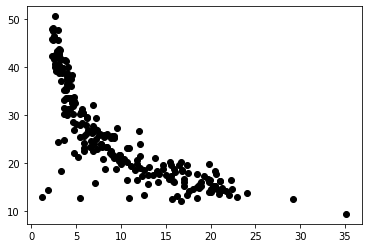

In [26]:
# Tasty curvilinear distribution evident here;
#   ++%pop==65+ has neatly acute-to-flat negative correl. with ++%pop==<15
#   "The most juniors (50%) is strongly matched with the least seniors (<5%), 
#       a correlation that quickly flattens out when %juniors gets below 20% 
pltSctr( df, [
    'People and Society: Age structure - 65 years and over',
    'People and Society: Age structure - 0-14 years' ] )

Feats: [ People and Society: Birth rate ]
       [ People and Society: Age structure - 15-24 years ]


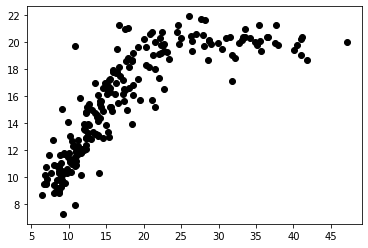

In [27]:
# The strong association of "higher birthrate with a bigger proportion of the 
#   pop%15-24yo" rapidly decreases after the birthrate hits around 20%;
#   after this point, that segment is relatively stable for higher birthrates. 
pltSctr( df, [
    'People and Society: Birth rate',
    'People and Society: Age structure - 15-24 years' ] )

Feats: [ Economy: Real GDP per capita ]
       [ People and Society: Mother's mean age at first birth ]


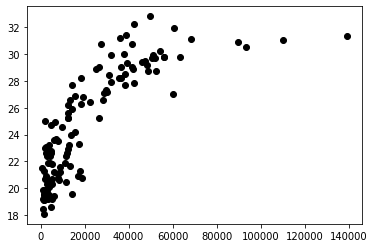

In [28]:
# Mothers are older in richer countries;
#   acutely so for gdp<"40000", then immediately flattening out 
pltSctr( df, [
    "Economy: Real GDP per capita",
    "People and Society: Mother's mean age at first birth" ] )

People and Society: Population growth rate


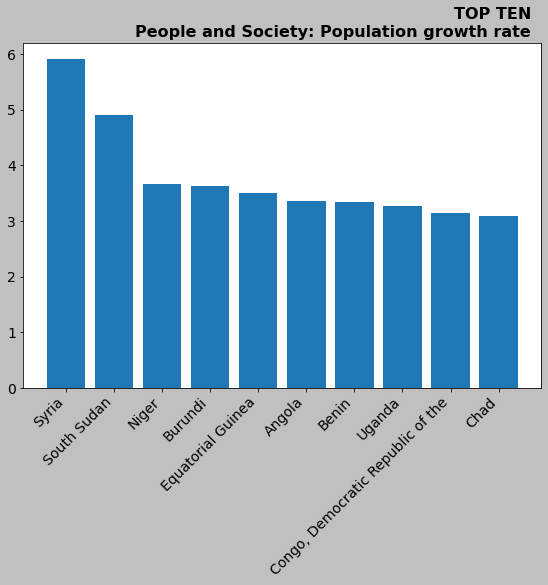

People and Society: Net migration rate


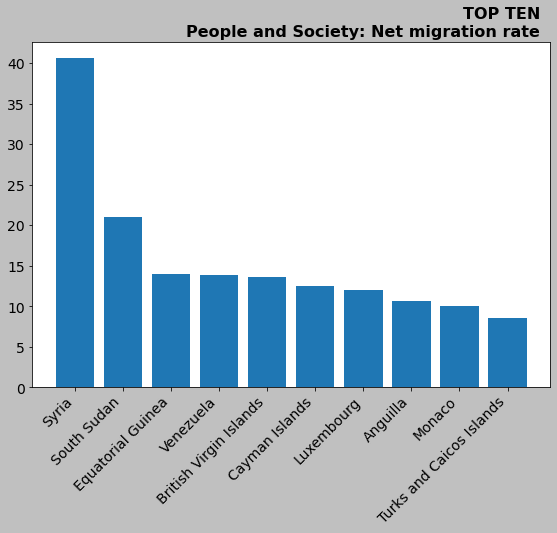

Feats: [ People and Society: Population growth rate ]
       [ People and Society: Net migration rate ]


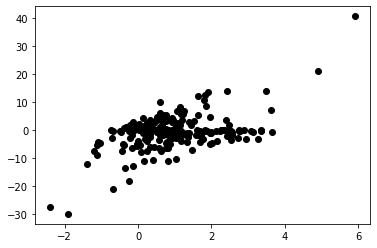

People and Society: Population growth rate


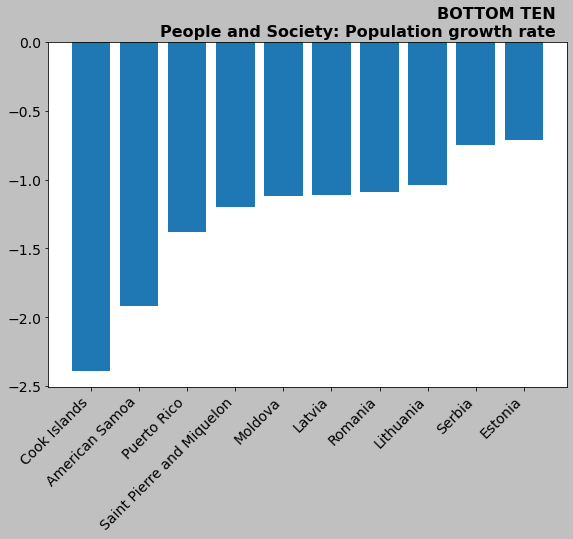

People and Society: Net migration rate


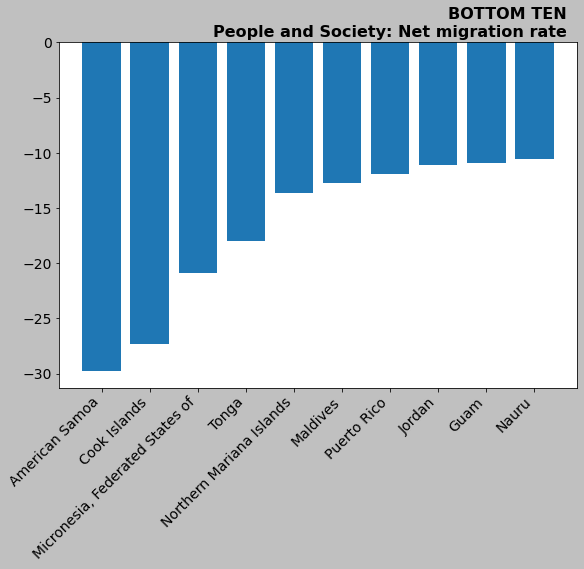

In [29]:
migration = 'People and Society: Population growth rate'
population = 'People and Society: Net migration rate'

showT10( migration, df )
showT10( population, df )

repCorr( df, corrDct, [ migration, population ] )
pltSctr( df, [ migration, population ] )

# Most emmigration, and populations in greatest contraction
# two very strong categories: either islands (esp. Pacific), or eastern Europe.
# (Jordan being the one exception)
showT10( migration, df, asc=True )
showT10( population, df, asc=True )

### COAL, ENGERY AND POLLUTION
#### Not a glitch: China's appetite

Energy: Coal - Production


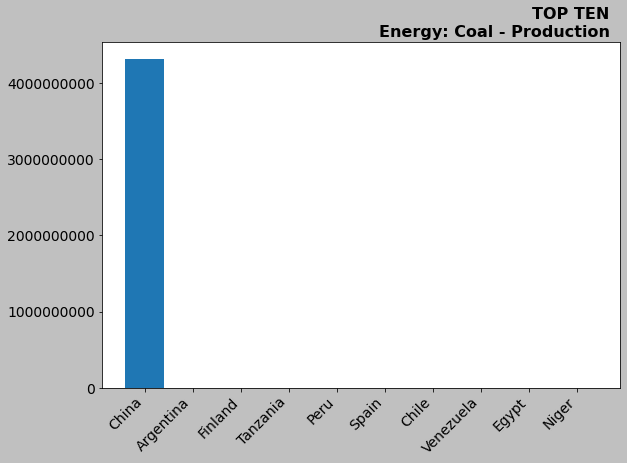

Energy: Coal - Consumption


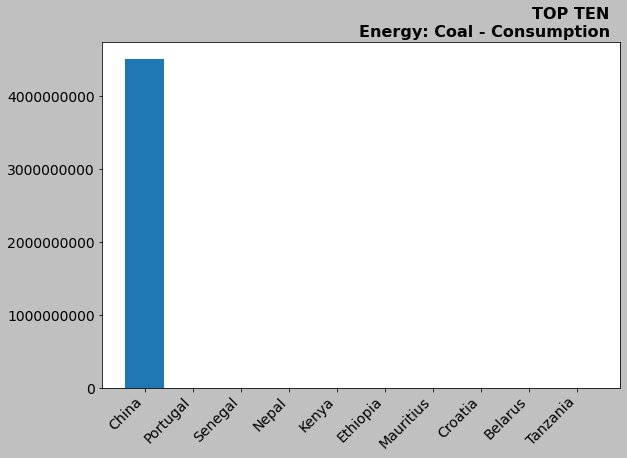

In [30]:
showT10( 'Energy: Coal - Production', df )
showT10( 'Energy: Coal - Consumption', df )

# compare: Energy: Electricity - Consumption

Just for scale, this is what the production of the top-ten coal producers 
looks like. More astonishingly, China remains a net importer - they consume 
this and more. The equivalent plot for consumption looks the same, except eg.
Australia disappears down to 200th in the world; quite a feat for the fourth-
largest producer, whereas the rest of the top ten producers are in the top ten 
consumers (excepting Kazakhstan, who drops out similarly as consumer to 198th).

In [31]:
# update this to return a percap or perGDP ranking.
getRank( df, 'Australia', 'Energy: Coal - Consumption' )
getRank( df, 'Kazakhstan', 'Energy: Coal - Consumption' )

With value of [ 99.048 ], Australia is 149th-highest for:
'Energy: Coal - Consumption'
(out of total 257 ranked)
With value of [ 74.819 ], Kazakhstan is 147th-highest for:
'Energy: Coal - Consumption'
(out of total 257 ranked)


Some figures in greater detail:

PRODUCTION: China's production is [ 1.09 ] times that of the rest of the 
world <br>
>   [ 4,314,681,000.00 ]: China's coal production<br>
>   [ 3,974,250,000.00 ]: rest of world combined<br>
 
CONSUMPTION: China's consumption is [ 1.27 ] times that of the rest of the 
world<br>
>   [ 4,506,387,000.00 ]: China's coal consumption<br>
>   [ 3,534,985,000.00 ]: rest of world combined<br>

In [32]:
prodFeat = 'Energy: Coal - Production'
consFeat = 'Energy: Coal - Consumption'

chinaProd = df[ df.Country == 'China' ][ prodFeat ].sum()
chinaCsmp = df[ df.Country == 'China' ][ consFeat ].sum()

notChinaProd = df[ df.Country != 'China' ][ prodFeat ].sum()
notChinaCsmp = df[ df.Country != 'China' ][ consFeat ].sum()

# get longest string length to pad report field
pad = (max( [ len( str( i ) )
    for i in [ chinaProd, notChinaProd, chinaCsmp, notChinaCsmp ] ] ))

print( f"PRODUCTION: China's production is "
       f"[ {(chinaProd / notChinaProd):,.2f} ] times that of the rest of world\n"
       f"   [ {chinaProd:>{pad},.2f} ]: China's coal production\n"
       f"   [ {notChinaProd:>{pad},.2f} ]: rest of world combined\n" )
print( f"\nCONSUMPTION: China's consumption is "
       f"[ {(chinaCsmp / notChinaCsmp):,.2f} ] times the size\n"
       f"of the rest of world combined.\n"
       f"   [ {chinaCsmp:>{pad},.2f} ]: China's coal consumption\n"
       f"   [ {notChinaCsmp:>{pad},.2f} ]: rest of world combined\n" )

PRODUCTION: China's production is [ 777.14 ] times that of the rest of world
   [   4,314,681,000.00 ]: China's coal production
   [       5,551,968.70 ]: rest of world combined


CONSUMPTION: China's consumption is [ 399.59 ] times the size
of the rest of world combined.
   [   4,506,387,000.00 ]: China's coal consumption
   [      11,277,523.71 ]: rest of world combined



Energy: Coal - Exports


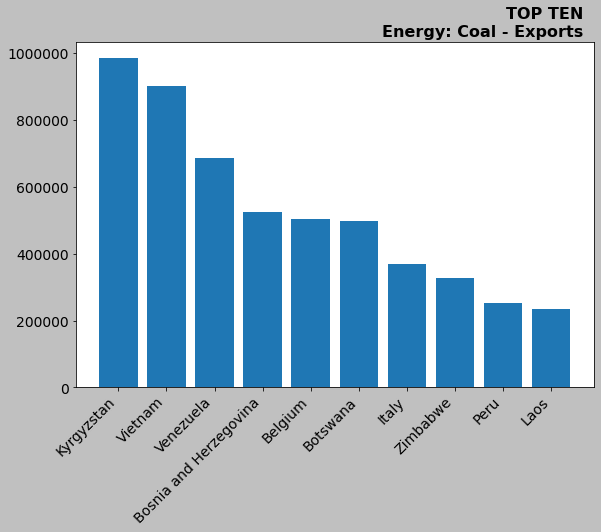

Coal: Exports-to-Total-Holdings ratio


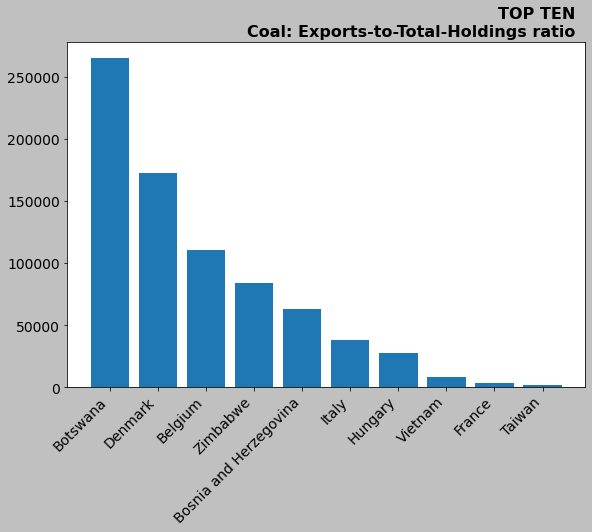

Environment: Revenue from coal - coal revenues


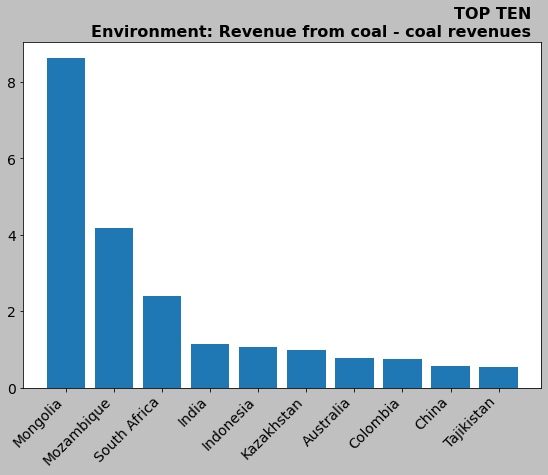

In [33]:
# Corroborating the disparity between production and consumption, the export
#   figures appear as follows.
showT10( 'Energy: Coal - Exports', df )

# We can get an image of a country's relationship with coal if we look at the 
#   combined production and imports in ratio to exports. Where this ratio is 
#   above one, a country has exported abve the total it produced and imported,
#   meaning it has sold reserves.
#   Refining this further to only the countries whose exports are above the
#   world-mean, we can see who has a strong reliance on coal exports.

df[ 'Coal: Exports-to-Total-Holdings ratio' ] = (
    df[ 'Energy: Coal - Exports' ] /
    (df[ 'Energy: Coal - Production' ] +
     df[ 'Energy: Coal - Imports' ]))

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, 'Energy: Coal - Exports' ].iloc[ 0 ]
    >= df[ 'Energy: Coal - Exports' ].mean()) ]

showT10( 'Coal: Exports-to-Total-Holdings ratio',
    df[ df[ 'Country' ].isin( aboveMeans ) ] )

# In order, the refinement exluded Venezuela, Belarus and Eswatini
# such that Russia, South Africa and the Phillipines entered the t10 "sellers"

# Environment: Revenue from coal - coal revenues
#   "% revenue derived from taxation on coal production"?
#   Compare with "Exports" [...]
showT10( 'Environment: Revenue from coal - coal revenues', df )

Environment: Air pollutants - carbon dioxide emissions


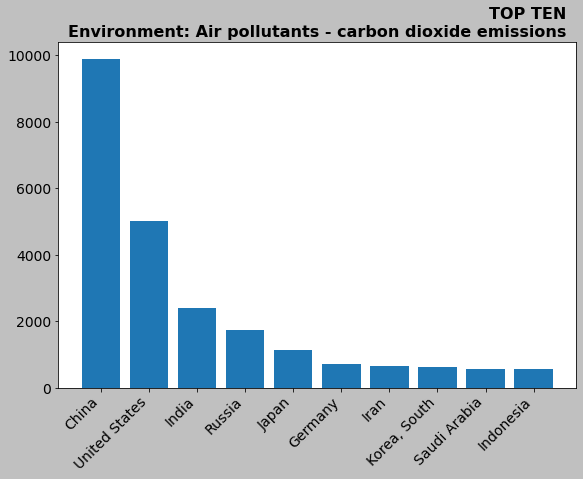

Feats: [ Energy: Coal - Consumption ]
       [ Energy: Carbon dioxide emissions - From coal and metallurgical coke ]


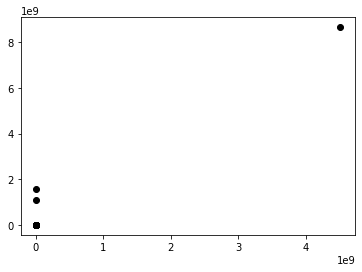

Coal/Metalurgical CO2 emissions BY Coal consumption


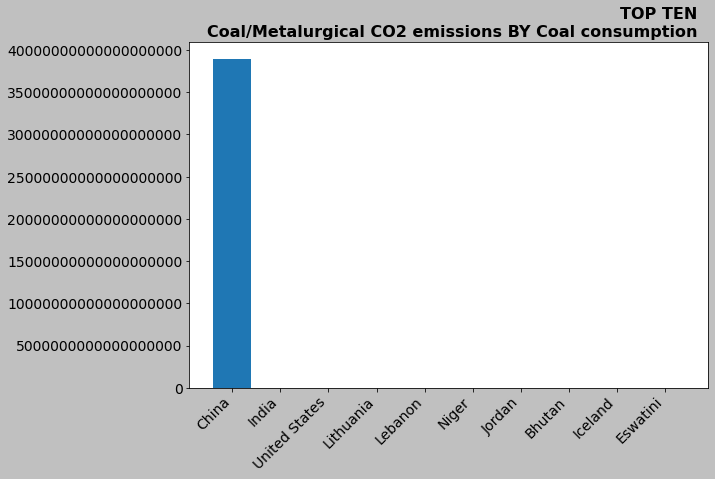

Coal/Metalurgical CO2 emissions PER Coal consumption


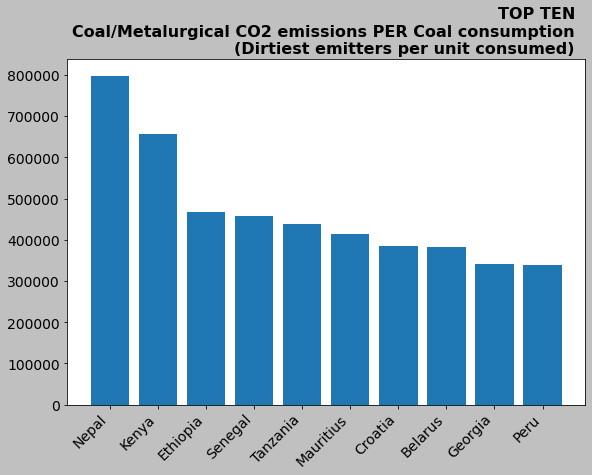

Coal/Metalurgical CO2 emissions PER Coal consumption


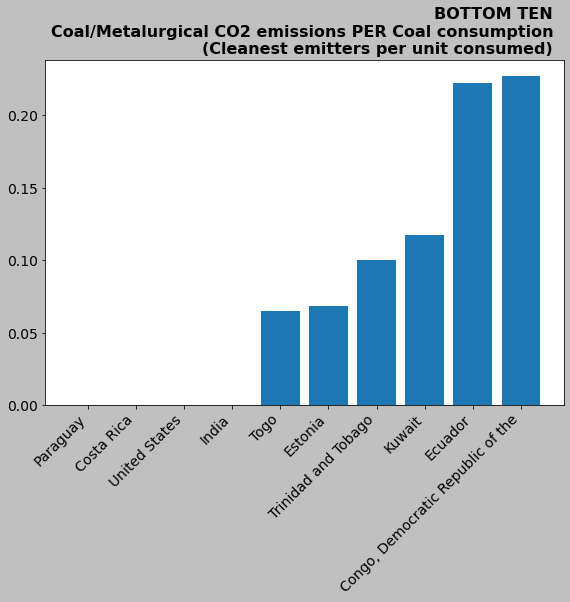

With value of [ 1000.0 ], Costa Rica is 158th-highest for:
'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
(out of total 257 ranked)


With value of [ 0.0 ], Costa Rica is 0th-highest for:
'Energy: Coal - Consumption'
(out of total 257 ranked)
TIED WITH 85 COUNTRIES


With value of [ 3000.0 ], Paraguay is 159th-highest for:
'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
(out of total 257 ranked)


With value of [ 0.0 ], Paraguay is 0th-highest for:
'Energy: Coal - Consumption'
(out of total 257 ranked)
TIED WITH 85 COUNTRIES




In [34]:
# Naturally, on the topic of coal, a look at the top CO2 emitters:

# CO2 EMISSIONS

showT10( 'Environment: Air pollutants - carbon dioxide emissions', df )
#   China leads by twice its nearest competitor, the US. See coal-relation (hah)
# Similar stats for Environment: Air pollutants - methane emission.

# The world's clustering for CO2 emissions vs coal consumption
#   China off in the distance
yFeat = 'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
pltSctr( df, [ 'Energy: Coal - Consumption', yFeat ] )

# identifying the extremes (each x by common y). 
df[ 'Coal/Metalurgical CO2 emissions BY Coal consumption' ] = (
    df[ yFeat ] * df[ 'Energy: Coal - Consumption' ])

showT10( 'Coal/Metalurgical CO2 emissions BY Coal consumption', df )

# While we are looking at these features, an interesting insight:
#   Scoring the dirtiest coal consumption. Hi there Australia!

df[ 'Coal/Metalurgical CO2 emissions PER Coal consumption' ] = (
    df[ 'Energy: Coal - Consumption' ] / df[ yFeat ])

showT10( 'Coal/Metalurgical CO2 emissions PER Coal consumption', df,
    subtitle='Dirtiest emitters per unit consumed' )
showT10( 'Coal/Metalurgical CO2 emissions PER Coal consumption', df,
    subtitle='Cleanest emitters per unit consumed', asc=True )

# Missing data for costa rica and paraguay?  - go back and dropna
for country in [ "Costa Rica", "Paraguay" ]:
    for feat in [
        'Energy: Carbon dioxide emissions - From coal and metallurgical coke',
        'Energy: Coal - Consumption'
        ]: getRank( df, country, feat ); print( '\n' )


#### ECONOMY


Feats: [ Economy: Budget - revenues ]
       [ Economy: Budget - expenditures ]


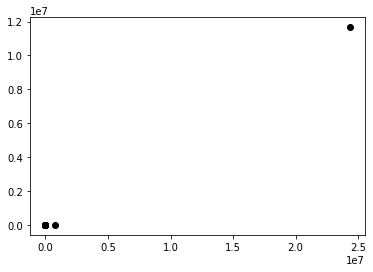

Economy: Real GDP (purchasing power parity)


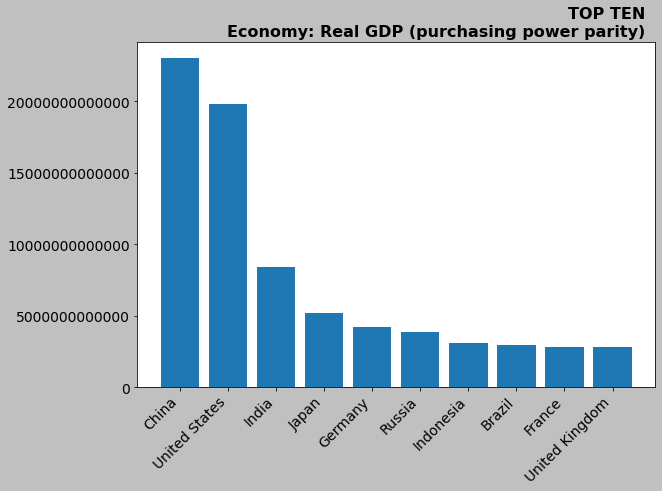

Economy: Real GDP (purchasing power parity)


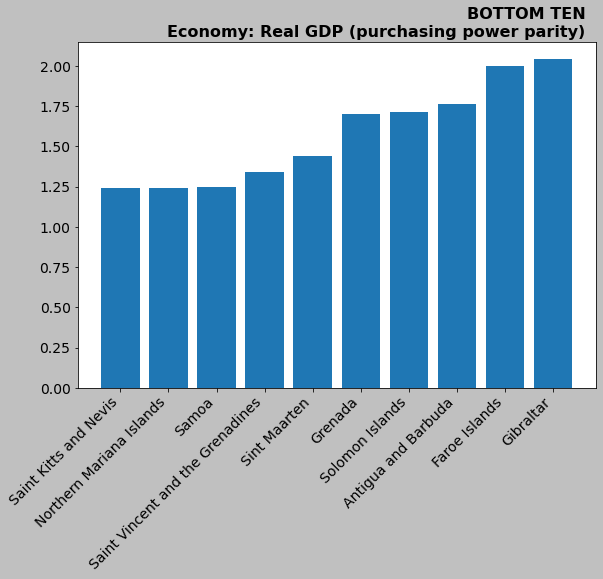

Economy: GDP - composition, by sector of origin - services


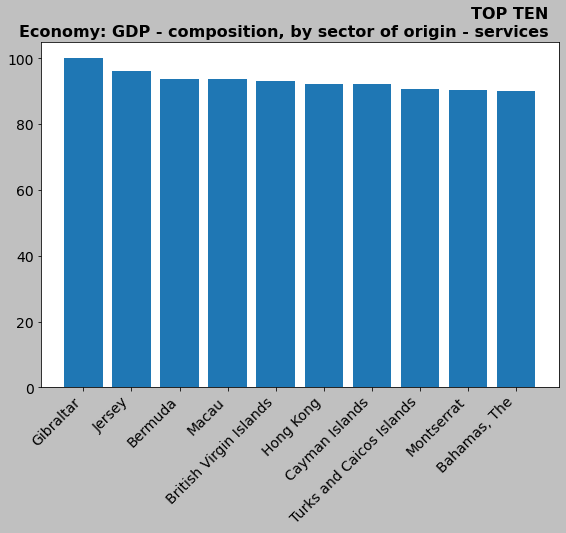

Economy: GDP - composition, by end use - household consumption


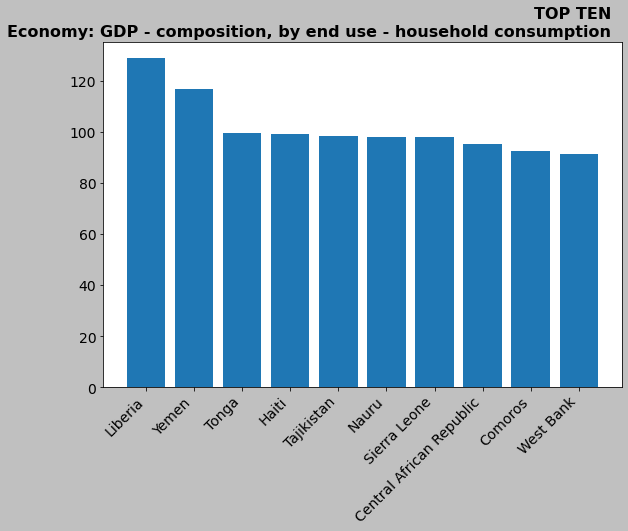

Economy: GDP - composition, by end use - household consumption


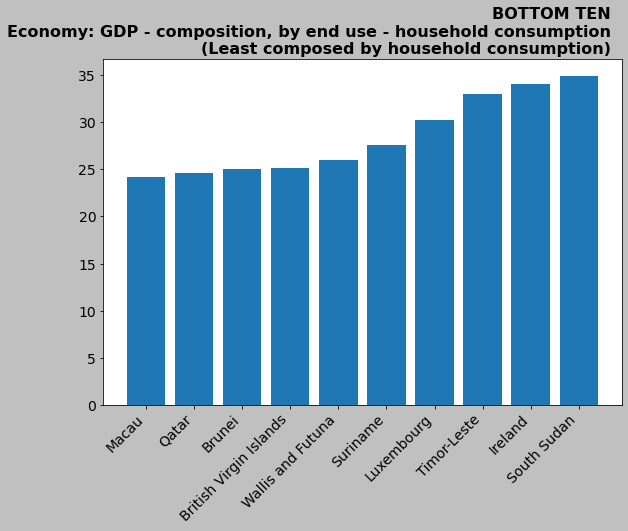

Economy: Inflation rate (consumer prices)


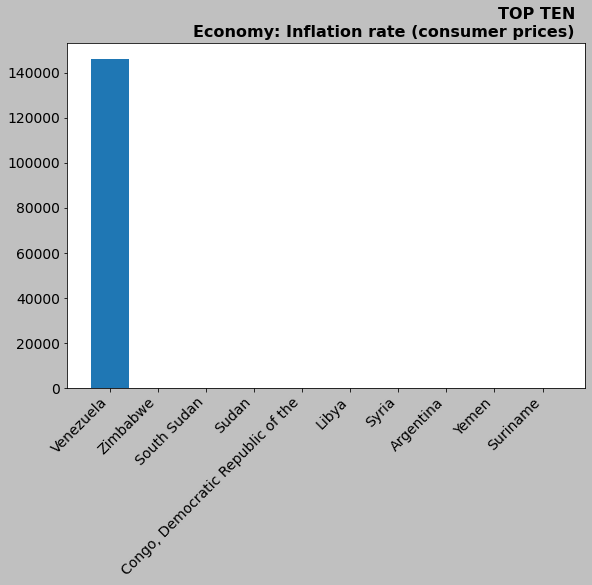

Economy: Inflation rate (consumer prices)


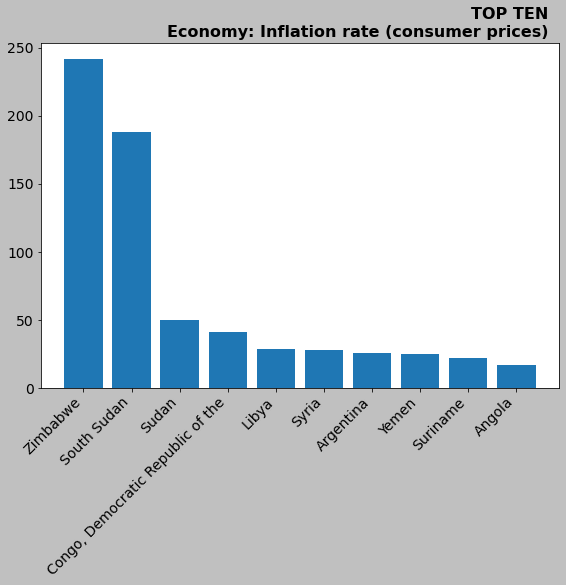

Economy: Inflation rate (consumer prices)


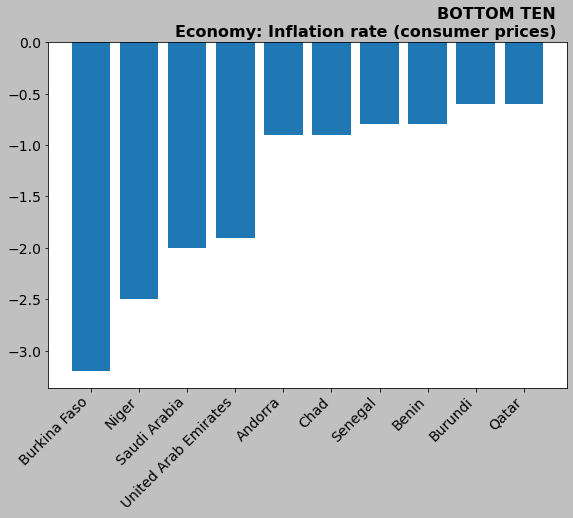

In [35]:
# If you tend to assume that countries usually spend close to what they make in 
#   revenue, take confidence from seeing how both rise together in 
#   very close proportion all the way from lowest to highest.
pltSctr( df, [
    'Economy: Budget - revenues',
    'Economy: Budget - expenditures' ] )

# GDP
showT10( 'Economy: Real GDP (purchasing power parity)', df )
showT10( 'Economy: Real GDP (purchasing power parity)', df, asc=True )
# Economy: Real GDP growth rate
# Economy: Real GDP per capita
# Economy: GDP (official exchange rate)
# Niue, Tokelau and Monstserrat consistenlty coming up in econ-B10s

# Interesting: which sovereignties pay the bills almost entirely from desk-work?
showT10( 'Economy: GDP - composition, by sector of origin - services', df )

# GDP driven by household spending. Interesting enough, but how can Liberia and 
#   Yemen be >100%?
# Economy: GDP - composition, by end use - household consumption
showT10( 'Economy: GDP - composition, by end use - household consumption', df )
showT10( 'Economy: GDP - composition, by end use - household consumption',
    df, asc=True, subtitle="Least composed by household consumption" )
# Economy: GDP - composition, by end use - government consumption
# Economy: GDP - composition, by end use - investment in fixed capital
# Economy: GDP - composition, by end use - investment in inventories

# Again, many places have >100% GDP from exports:
# Economy: GDP - composition, by end use - exports of goods and services
# on this topic: Maldives is a startling sole-case of GDP from G-S imports.
#   Economy: GDP - composition, by end use - imports of goods and services

# Inflation
#   Venezuela dwarfs the world.
showT10( 'Economy: Inflation rate (consumer prices)', df )
showT10( 'Economy: Inflation rate (consumer prices)',
    df[ df[ 'Country' ] != 'Venezuela' ] )  # without Venezueal
showT10( 'Economy: Inflation rate (consumer prices)', df, asc=True )

Labour force as a percentage of population


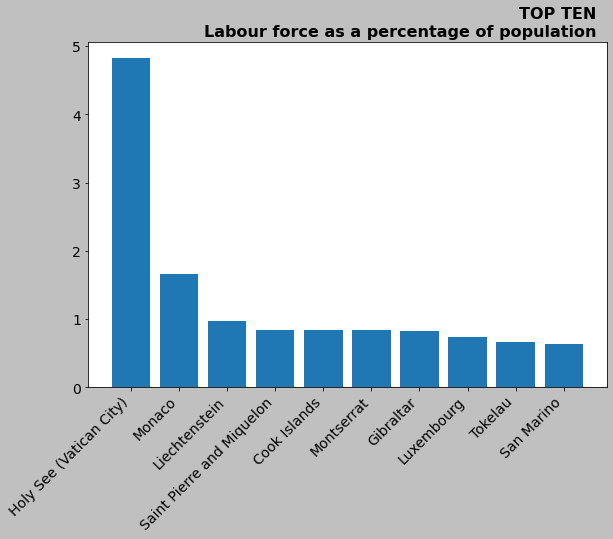

Labour force as a percentage of population


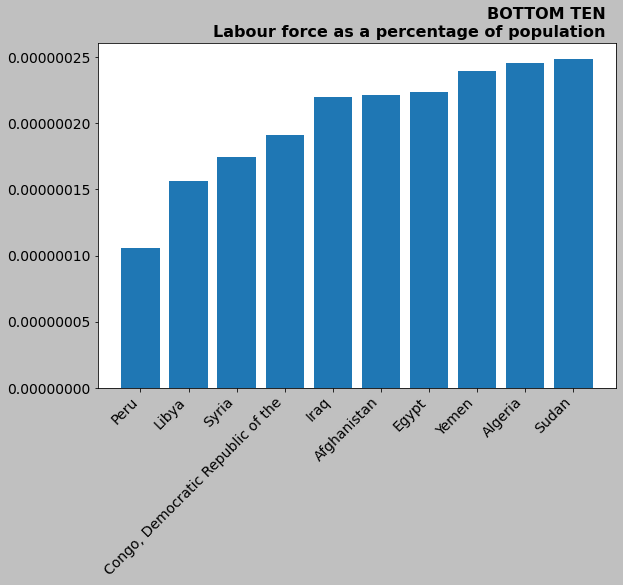

In [36]:
# compare with pop: Economy: Labor force
# Labour force as a percentage of population. 
# LForce obviously includes migrant workers. 
df[ 'Labour force as a percentage of population' ] = (
    df[ 'Economy: Labor force' ] /
    df[ 'People and Society: Population' ])

showT10( 'Labour force as a percentage of population', df )
showT10( 'Labour force as a percentage of population', df, asc=True )
# In these countries, even including cross-border commuters, there is less than
#   0.2 of a "labour force" indiv. for every indiv. counted in the population.

Economy: Labor force - by occupation - agriculture


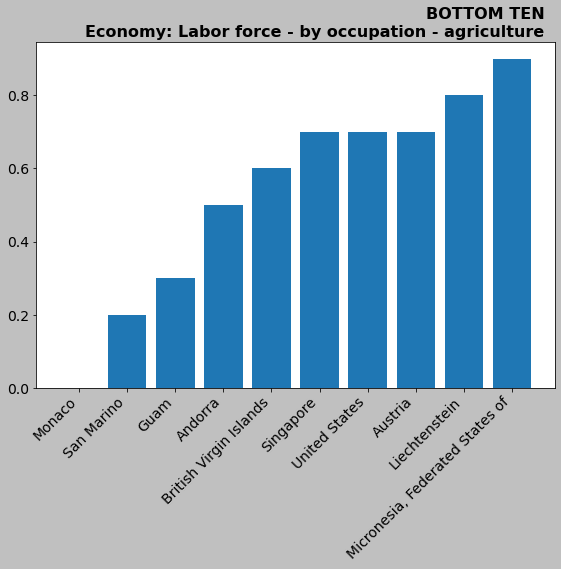

Agriculture: GDP composition to labour


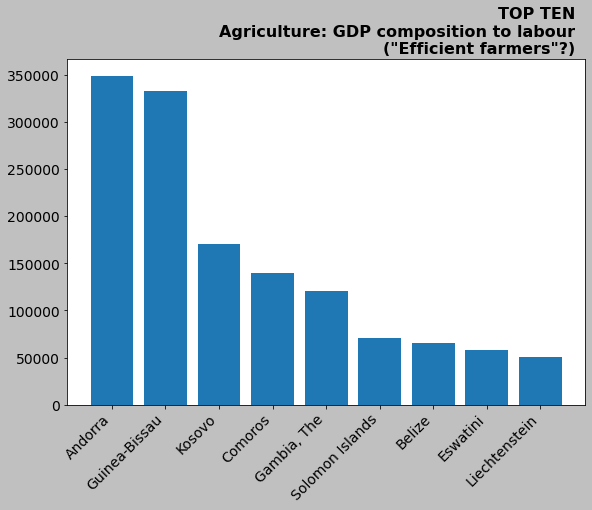

In [37]:
dfPop = pd.concat( [
    dffBook[ 'Country' ],
    dffBook[ 'People and Society: Population' ],
    dffBook[ 'Economy: Labor force' ],
    dffBook[ 'Economy: Labor force - by occupation - agriculture' ] ],
    axis=1 )

tongaLforce = dfPop[ dfPop[ 'Country' ] == "Tonga" ]

# Error in the data for Tonga (date taken as percent)
# Excluding Tonga, the surprise in the bottom ten is the USA - only ~0.7% of 
#   workers are in agriculture?
showT10( 'Economy: Labor force - by occupation - agriculture',
    df[ df[ 'Country' ] != "Tonga" ], asc=True )

# TONGA labour force stats all error (taken date as value)
# print(dffBook[ 'Economy: Labor force - by occupation - agriculture' ].loc[ dffBook[ 'Country' ] == 'Tonga' ].values[ 0 ])
# print(dfFbDict['Economy: Labor force - by occupation - agriculture']['matchedNums'])

# Leads to the question: who has the highest Agri-portion of GDP in ratio to
#   the Agri-portion of the labour force (an estimate of agri-automation?)

df[ 'Agriculture: GDP composition to labour' ] = ((
    df[ 'Economy: GDP - composition, by sector of origin - agriculture' ] /
    df[ 'Economy: GDP (official exchange rate)' ])) / ((
    df[ 'Economy: Labor force - by occupation - agriculture' ] /
    df[ 'Economy: Labor force' ]))

showT10( 'Agriculture: GDP composition to labour',
    df[ df[ 'Country' ] != "Tonga" ], subtitle="\"Efficient farmers\"?" )

Economy: Gini Index coefficient - distribution of family income


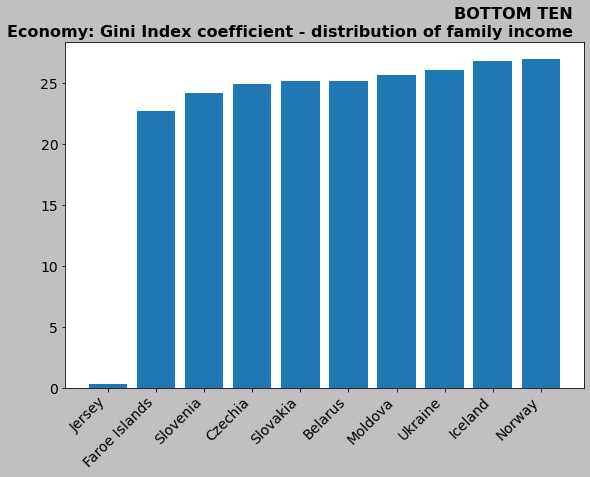

Economy: Gini Index coefficient - distribution of family income


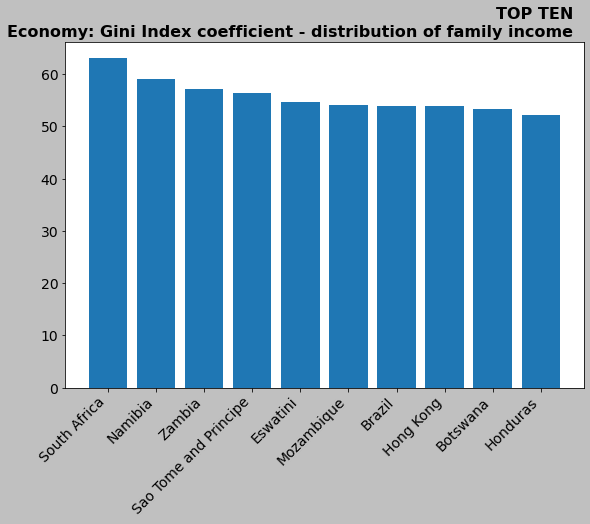

In [38]:
# The most-equal countries have a strong representation of East 
# Eurpoean countries, along with Social Democracy commentators' darling, 
#   Norway. Jersey and Faroe would need to be more closely vetted.
showT10( 'Economy: Gini Index coefficient - distribution of family income',
    df, asc=True )

# The least-equal countries most strongly feature Southern African nations.
showT10( 'Economy: Gini Index coefficient - distribution of family income',
    df )

#### GEOGRAPHY AND ENVIRONMENT


Geography: Area - total


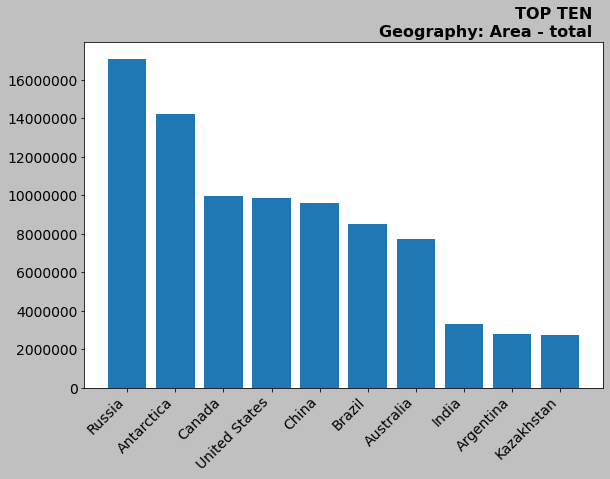

In [39]:
# largest countries. 
showT10( 'Geography: Area - total', df )

Water-area ratio


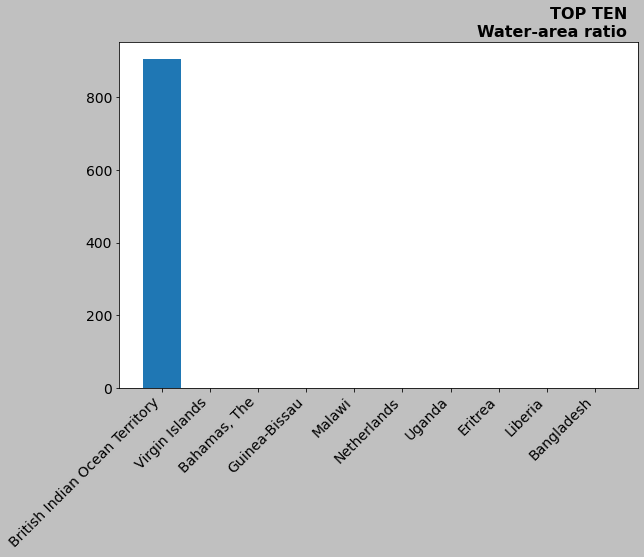

In [40]:
# highest percent water area
df[ 'Water-area ratio' ] = (
    df[ 'Geography: Area - water' ] /
    df[ 'Geography: Area - total' ])
showT10( 'Water-area ratio', df )

The British Indian Ocean territory value here is an outlier arising from an
apparent inconsistency or ambiguity in geographic description - 
the territory is designated across a very disparate grouping of islands which 
are themselves thin segments of atolls or whole/partial atolls with large 
inner bodies of water. Some interesting reading both for observers of 
colonialism and for ongoing events in the projection of sovereign power 
across large sea vectors:


#### British Indian Ocean Territory
![British_Indian_Ocean_Territory](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/British_Indian_Ocean_Territory_in_United_Kingdom.svg/1466px-British_Indian_Ocean_Territory_in_United_Kingdom.svg.png)

WIKI: 
>The only inhabitants are British and U.S. military personnel and associated 
contractors, who collectively number around 3,000 (2018 figures). The 
forced removal of Chagossians from the Chagos Archipelago occurred between 
1968 and 1973. [...] Today, the exiled Chagossians are still trying 
to return, saying that the forced expulsion and dispossession was unlawful, 
but the UK government has repeatedly denied them the right of return. The 
islands are off-limits to Chagossians, casual tourists, and the media.


Water-area ratio


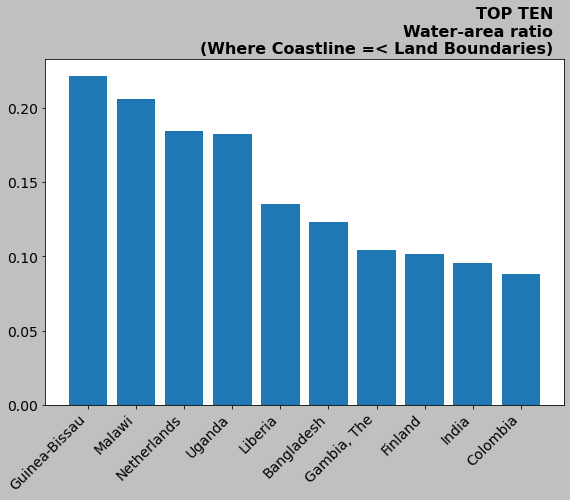

In [41]:
showT10( 'Water-area ratio',
    df[ df[ 'Geography: Land boundaries - total' ] >=
        df[ 'Geography: Coastline' ] ],
    subtitle="Where Coastline =< Land Boundaries" )

Excluding BIOT as an outlier should reveal a more intuitive distribution.
Better yet, to avoid catching so many islands, let's filter down to countries 
whose coastline is no longer than their land boundaries with other countries.

Water-area ratio


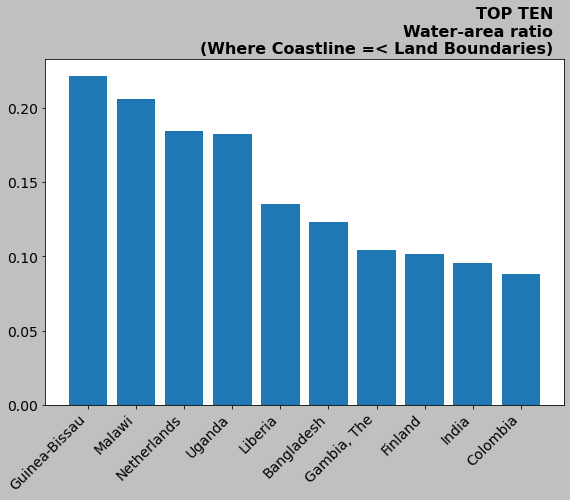

In [42]:
showT10( 'Water-area ratio',
    df[ df[ 'Geography: Land boundaries - total' ] >=
        df[ 'Geography: Coastline' ] ],
    subtitle="Where Coastline =< Land Boundaries" )

##### The coastline paradox
All coastlines are infinitely long, at least if you keep decreasing the unit of 
measurement. The "longest coast" could (at least logically) change for some 
smaller unit, given that it might may discover an underlying "flatness" in the 
reigning longest coastline, while discovering an underlying "texture" in the 
land boundary of another territory which produces a greater overall length
(see [here](https://medium.com/@drewjosselyn/fun-with-fractals-using-fractals-to-measure-the-coastline-length-of-one-of-canadas-most-iconic-16c3266af782)).

Nonetheless, at any scale, given the extent and countour of Canada's polar coast,
it seems likely remain out in front at any unit of measurement.

Geography: Coastline


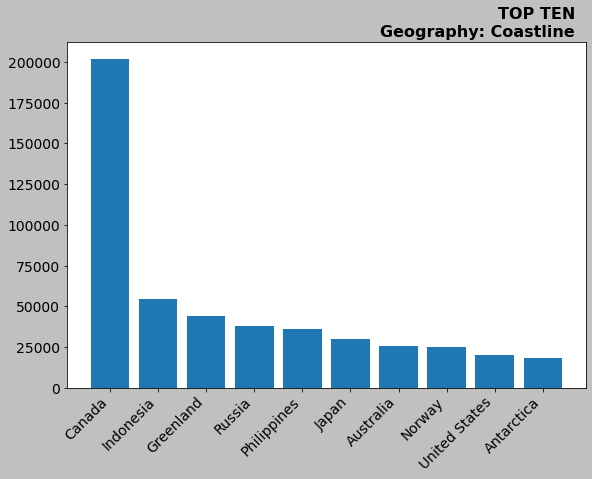

In [43]:
showT10( 'Geography: Coastline', df )

Elevation difference

Maximum elevation difference


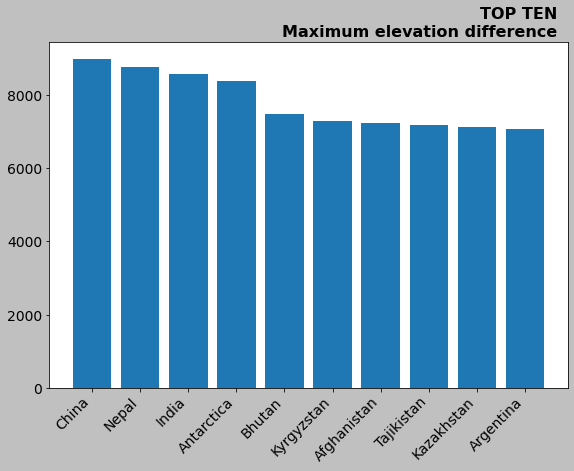

In [44]:
df[ 'Maximum elevation difference' ] = (
    df[ 'Geography: Elevation - highest point' ] -
    df[ 'Geography: Elevation - lowest point' ])
showT10( 'Maximum elevation difference', df )

Countries with the largest difference between their lowest and highest point.
While the China-Nepal border dissects Siggamartha's highest point, China 
itself has a lower minimum elevation than Nepal.

Flattest places in the world: no point on natural ground is at an ascent of
more of than five meters from any other point. At #4 in the world, Pakistan's 
current floods are devastating partly due to this marked flatness.

Cayman Islands is easiest on the hips with a M.E.D of one meter.

Maximum elevation difference


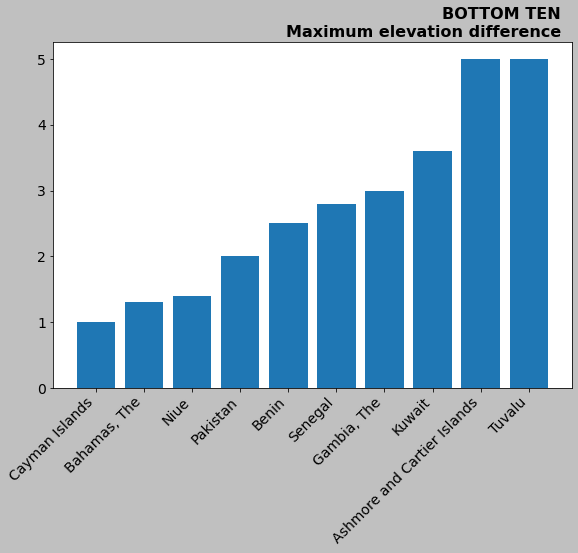

In [45]:
showT10( 'Maximum elevation difference', df, asc=True )

Environment: Land use - forest


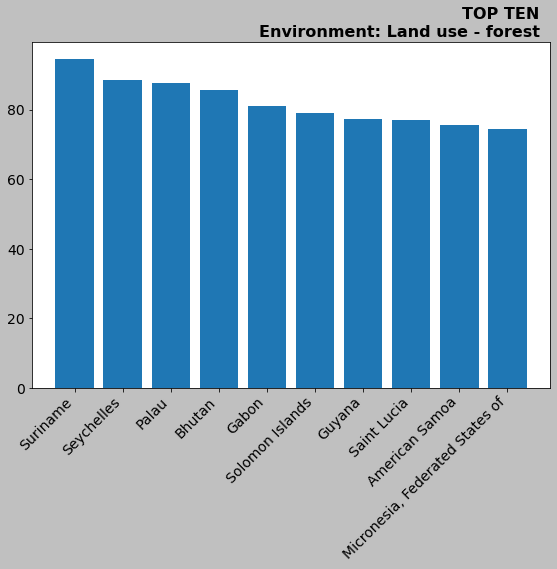

With value of [ 2.36 ], Suriname is 174th-highest for:
'Environment: Revenue from forest resources - forest revenues'
(out of total 257 ranked)


In [46]:
# A pleasant pit-stop in the forests of Suriname:
showT10( 'Environment: Land use - forest', df )

# interestingly, Suriname does very little to leverage this as a resource 
#   advantage - Suriname's rank in %rev Forst rsrc is 174th.

getRank( df, 'Suriname',
    'Environment: Revenue from forest resources - forest revenues' )
    
# correl/sctr?

Environment: Urbanization - urban population


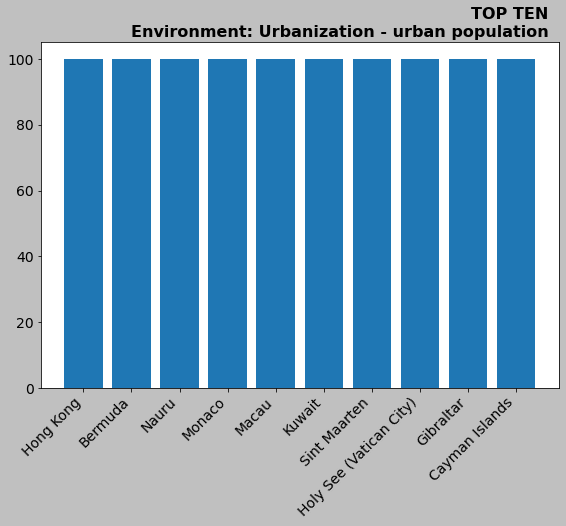

Environment: Urbanization - urban population


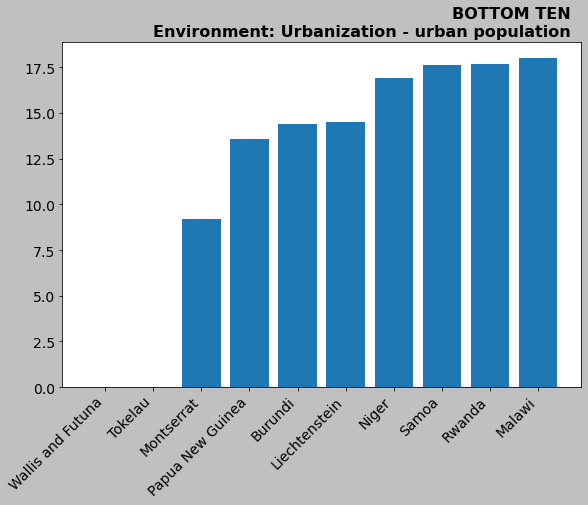

In [47]:
#   Fairly even, City-States understandably dominating the top 10. 
showT10( 'Environment: Urbanization - urban population', df )
showT10( 'Environment: Urbanization - urban population', df, asc=True )

# Of the least-urbanised, several are pacific territories with relatively 
#   unfamiliar names: Wallis and Futuna (FR), Montserrat (UK) and Tokelau (NZ). 
#   To help with attribution, if not decolonization, I submit that the UK and 
#   French territories swap names.

# Liechtenstein... is also there.
# "It is a testimony to the mere political expediency of the purchase that the Princes of Liechtenstein did not visit 
#   their new principality for almost 100 years." [citation needed]

Water withdrawal exposure to trade


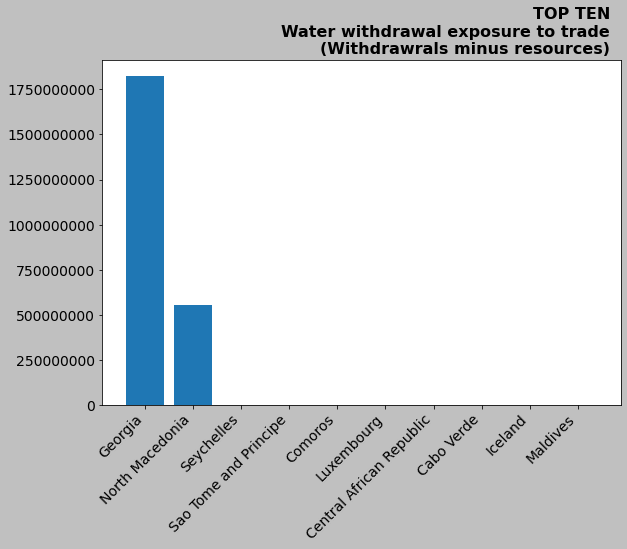

Water withdrawal exposure to trade


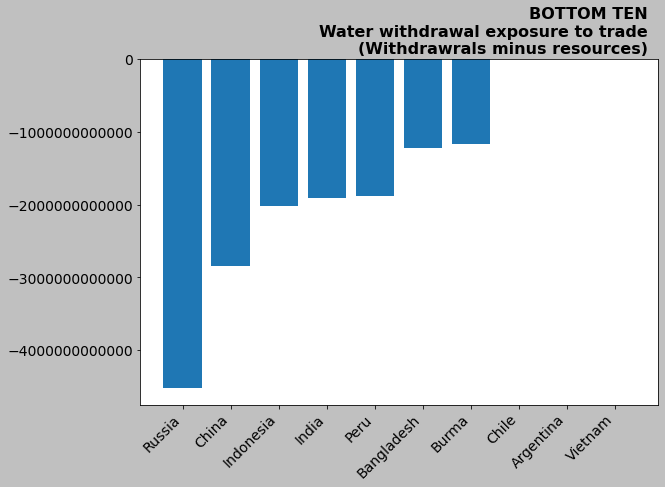

In [48]:
# Who are the most and least trade-reliant for water? (Hi there, Middle East)
# Withdrawrals (municipal, industrial and agricultural) minus renewable sources
df[ 'Water withdrawal exposure to trade' ] = (
    (df[ 'Environment: Total water withdrawal - municipal' ] +
     df[ 'Environment: Total water withdrawal - industrial' ] +
     df[ 'Environment: Total water withdrawal - agricultural' ]) -
    df[ 'Environment: Total renewable water resources' ])

showT10( 'Water withdrawal exposure to trade', df,
    subtitle="Withdrawrals minus resources" )

# Brazil is sitting happy there around the Amazon. Russia and Canada just 
# melt vast amounts of snow.
showT10( 'Water withdrawal exposure to trade', df, asc=True,
    subtitle="Withdrawrals minus resources" )

Irrigated-area ratio


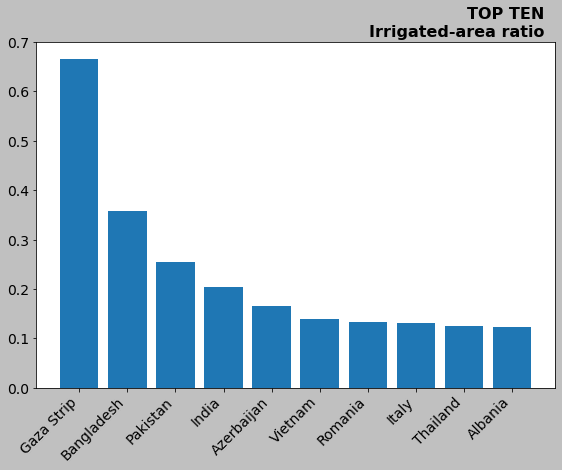

Irrigated area in Gaza Strip is 240.0 sqkm
Total area of Gaza Strip is 360.0 sqkm


In [49]:
#### Ratio of irrigated land to total land

df[ 'Irrigated-area ratio' ] = (
    df[ 'Geography: Irrigated land' ] /
    df[ 'Geography: Area - total' ])
showT10( 'Irrigated-area ratio', df )

print( f"Irrigated area in Gaza Strip is "
       f"{getVal( df, 'Gaza Strip', 'Geography: Irrigated land' )} sqkm" )

print( f"Total area of Gaza Strip is "
       f"{getVal( df, 'Gaza Strip', 'Geography: Area - total' )} sqkm" )


Many members of this T10 may not surprise, as familiar origins of agricultural 
commodities, but the Gaza Strip may conjure a more arid image. The rank comes 
down to proportion and population: irrigation, as a [vital element of food production](https://socialsciences.mcmaster.ca/kubursi/ebooks/water.htm), 
takes up 240 of the territory's total 360 square kilometers, which is the third 
most densely populated territory in the world.

<font color='red'> In fact, population density and irrigated area ratio... [SCATTER]
</font>

Government: National heritage - total World Heritage Sites


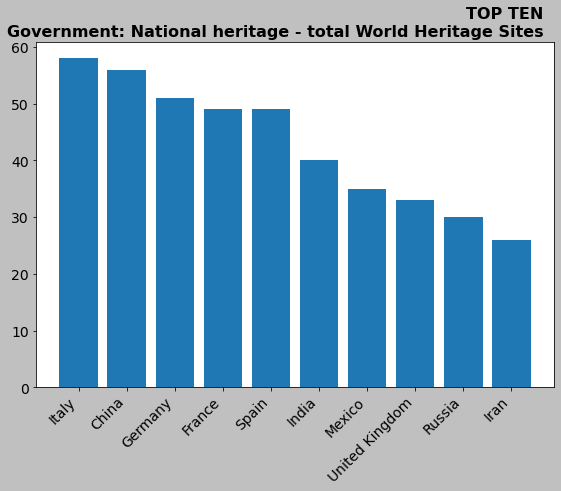

In [50]:
showT10( 'Government: National heritage - total World Heritage Sites', df )
# the anti-empire question: what qualifies as world heritage? 
# -> All t10 is high-GDP (corrob.)

In [51]:
# In the course of this study, small island groups (many with colonial 
# names) I'm not familiar with keep showing up. Would like to dive into more 
# detail on each of these.

# the Kooky Islands Krew (ctIslands)
#   appears frequently on the bottom/top ten because it is takes less
#   of an event in global terms to have a proportionately large effect
#   on the small sample, be it a population, an area total and so on. 

kookyIslands = [
    'Anguilla',
    'Ashmore and Cartier Islands',
    'British Indian Ocean Territory',
    'British Virgin Islands',
    'Cape Verde',
    'Cayman Islands',
    'Cocos (Keeling) Islands',
    'Comoros',
    'Faroe Islands',
    'Montserrat',
    'Northern Mariana Islands',
    'Saint Barthelemy',
    'Saint Kitts and Nevis',
    'Saint Lucia',
    'Saint Pierre and Miquelon',
    'Saint Vincent and the Grenadines',
    'San Marino',
    'Sao Tome and Principe',
    'Tokelau',
    'Turks and Caicos Islands',
    'Wallis and Futuna' ]

In [52]:
# Things that China is in the top-ten/5/3/1 of
# (Who else are the "most top 10/5/3/1" countries?)
# combine bottom-tens somehow?

In [53]:
# FINALIZING:

# Add positional bar colour-gradient to barplots
#   https://stackoverflow.com/questions/60220089/how-to-add-color-gradients-according-to-y-value-to-a-bar-plot
# Generate unitDct which vis. fetches for feature by column key
# Group t10s and scatterplots by subject.
# move all/most defs to imports, except where important for process comm.